In [1]:
# Import all required libraries
import pandas as pd
import numpy as np
import pingouin as pg
from pathlib import Path
from scipy import stats
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import os.path as op
import re

In [2]:
# Setup directories and plotting theme
ANNOT_DIR = Path("derivatives/annotations")
OUT_DIR = Path("derivatives/caps/interrater")
FIGURES_DIR = Path("derivatives/figures")

# Create directories
OUT_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Configure plotting theme
sns.set_theme(style="darkgrid")

# Define colors for consistent plotting
colors = ['#CF9397', "#606933", '#E5D28E', '#715958', '#AC9B74', '#8c564b', '#e377c2', '#BCB5BB']

In [3]:
# Inter-Rater Reliability Analysis: ICC + Spearman Correlation
print("Calculating Inter-Rater Reliability: ICC + Spearman Correlation")

# Results storage
overall_results = []
run_results = []

episode_numbers = [1, 2, 3, 4]

# Process each episode
for ep_num in episode_numbers:
    episode_file = ANNOT_DIR / f"S01E{ep_num:02d}.csv"
    episode_name = Path(episode_file).stem
    episode_df = pd.read_csv(episode_file)
    
    # Find rating columns
    val_cols = [c for c in episode_df.columns if 'valence' in c.lower()]
    aro_cols = [c for c in episode_df.columns if 'arousal' in c.lower()]
    
    # Extract clip and run info
    pattern = rf"{re.escape(episode_name)}R\d{{2}}_clip(\d+)"
    extracted = episode_df['index'].astype(str).str.extract(pattern, expand=False)
    
    episode_df = episode_df[extracted.notna()].copy()
    episode_df['clip_number'] = extracted[extracted.notna()].astype(int)
    episode_df['run_number'] = episode_df['run'].str.extract(r'R(\d+)').astype(int)
    episode_df['episode'] = ep_num
    
    # Create target ID for ICC
    episode_df['target_id'] = (episode_df['episode'].astype(str) + '_' + 
                              episode_df['run_number'].astype(str) + '_' + 
                              episode_df['clip_number'].astype(str))
    
    # ===== OVERALL EPISODE ANALYSIS =====
    
    # Prepare data for overall ICC (all runs combined)
    if len(val_cols) >= 2:
        valence_long = episode_df.melt(
            id_vars=['target_id'], value_vars=val_cols,
            var_name='rater', value_name='valence'
        )
        valence_long['rater'] = valence_long['rater'].str.extract(r'(\d+)').astype(int)
        valence_long['valence'] = pd.to_numeric(valence_long['valence'], errors='coerce')
        valence_long = valence_long.dropna()
        
        # Calculate overall ICC for valence
        val_icc = val_ci_lower = val_ci_upper = val_icc_p = None
        try:
            if len(valence_long) > 0:
                icc_result = pg.intraclass_corr(data=valence_long, targets='target_id', 
                                              raters='rater', ratings='valence', nan_policy='omit')
                icc2_val = icc_result[icc_result['Type'] == 'ICC2'].iloc[0]
                val_icc = icc2_val['ICC']
                val_ci_lower = icc2_val['CI95%'][0]
                val_ci_upper = icc2_val['CI95%'][1]
                val_icc_p = icc2_val['pval']
        except: pass
        
        # Calculate overall Spearman for valence
        val_spearman = val_spearman_p = None
        try:
            val1_data = pd.to_numeric(episode_df[val_cols[0]], errors='coerce').dropna()
            val2_data = pd.to_numeric(episode_df[val_cols[1]], errors='coerce').dropna()
            common_idx = val1_data.index.intersection(val2_data.index)
            if len(common_idx) > 2:
                val_spearman, val_spearman_p = spearmanr(val1_data.loc[common_idx], val2_data.loc[common_idx])
        except: pass
    
    if len(aro_cols) >= 2:
        arousal_long = episode_df.melt(
            id_vars=['target_id'], value_vars=aro_cols,
            var_name='rater', value_name='arousal'
        )
        arousal_long['rater'] = arousal_long['rater'].str.extract(r'(\d+)').astype(int)
        arousal_long['arousal'] = pd.to_numeric(arousal_long['arousal'], errors='coerce')
        arousal_long = arousal_long.dropna()
        
        # Calculate overall ICC for arousal
        aro_icc = aro_ci_lower = aro_ci_upper = aro_icc_p = None
        try:
            if len(arousal_long) > 0:
                icc_result = pg.intraclass_corr(data=arousal_long, targets='target_id', 
                                              raters='rater', ratings='arousal', nan_policy='omit')
                icc2_aro = icc_result[icc_result['Type'] == 'ICC2'].iloc[0]
                aro_icc = icc2_aro['ICC']
                aro_ci_lower = icc2_aro['CI95%'][0]
                aro_ci_upper = icc2_aro['CI95%'][1]
                aro_icc_p = icc2_aro['pval']
        except: pass
        
        # Calculate overall Spearman for arousal
        aro_spearman = aro_spearman_p = None
        try:
            aro1_data = pd.to_numeric(episode_df[aro_cols[0]], errors='coerce').dropna()
            aro2_data = pd.to_numeric(episode_df[aro_cols[1]], errors='coerce').dropna()
            common_idx = aro1_data.index.intersection(aro2_data.index)
            if len(common_idx) > 2:
                aro_spearman, aro_spearman_p = spearmanr(aro1_data.loc[common_idx], aro2_data.loc[common_idx])
        except: pass
    
    # Store overall episode results
    overall_results.append({
        'Episode': ep_num,
        'N_clips': len(episode_df),
        'Valence_ICC': val_icc,
        'Valence_ICC_CI_Lower': val_ci_lower,
        'Valence_ICC_CI_Upper': val_ci_upper,
        'Valence_ICC_pval': val_icc_p,
        'Valence_Spearman_r': val_spearman,
        'Valence_Spearman_pval': val_spearman_p,
        'Arousal_ICC': aro_icc,
        'Arousal_ICC_CI_Lower': aro_ci_lower,
        'Arousal_ICC_CI_Upper': aro_ci_upper,
        'Arousal_ICC_pval': aro_icc_p,
        'Arousal_Spearman_r': aro_spearman,
        'Arousal_Spearman_pval': aro_spearman_p
    })
    
    # ===== RUN-BY-RUN ANALYSIS =====
    
    unique_runs = sorted(episode_df['run_number'].unique())
    for run_num in unique_runs:
        run_data = episode_df[episode_df['run_number'] == run_num].copy()
        run_data['target_id'] = (run_data['episode'].astype(str) + '_' + 
                                run_data['run_number'].astype(str) + '_' + 
                                run_data['clip_number'].astype(str))
        
        run_result = {
            'Episode': ep_num, 'Run': run_num, 'N_clips': len(run_data),
            'Valence_ICC': None, 'Valence_ICC_CI_Lower': None, 'Valence_ICC_CI_Upper': None, 'Valence_ICC_pval': None,
            'Valence_Spearman_r': None, 'Valence_Spearman_pval': None,
            'Arousal_ICC': None, 'Arousal_ICC_CI_Lower': None, 'Arousal_ICC_CI_Upper': None, 'Arousal_ICC_pval': None,
            'Arousal_Spearman_r': None, 'Arousal_Spearman_pval': None
        }
        
        # Valence analysis for this run
        if len(val_cols) >= 2:
            try:
                valence_long = run_data.melt(id_vars=['target_id'], value_vars=val_cols,
                                           var_name='rater', value_name='valence')
                valence_long['rater'] = valence_long['rater'].str.extract(r'(\d+)').astype(int)
                valence_long['valence'] = pd.to_numeric(valence_long['valence'], errors='coerce')
                valence_long = valence_long.dropna()
                
                if len(valence_long) > 0:
                    # ICC
                    icc_result = pg.intraclass_corr(data=valence_long, targets='target_id', 
                                                  raters='rater', ratings='valence', nan_policy='omit')
                    icc2_val = icc_result[icc_result['Type'] == 'ICC2'].iloc[0]
                    run_result['Valence_ICC'] = icc2_val['ICC']
                    run_result['Valence_ICC_CI_Lower'] = icc2_val['CI95%'][0]
                    run_result['Valence_ICC_CI_Upper'] = icc2_val['CI95%'][1]
                    run_result['Valence_ICC_pval'] = icc2_val['pval']
                    
                    # Spearman
                    val1_data = pd.to_numeric(run_data[val_cols[0]], errors='coerce').dropna()
                    val2_data = pd.to_numeric(run_data[val_cols[1]], errors='coerce').dropna()
                    common_idx = val1_data.index.intersection(val2_data.index)
                    if len(common_idx) > 2:
                        spearman_r, spearman_p = spearmanr(val1_data.loc[common_idx], val2_data.loc[common_idx])
                        run_result['Valence_Spearman_r'] = spearman_r
                        run_result['Valence_Spearman_pval'] = spearman_p
            except: pass
        
        # Arousal analysis for this run
        if len(aro_cols) >= 2:
            try:
                arousal_long = run_data.melt(id_vars=['target_id'], value_vars=aro_cols,
                                           var_name='rater', value_name='arousal')
                arousal_long['rater'] = arousal_long['rater'].str.extract(r'(\d+)').astype(int)
                arousal_long['arousal'] = pd.to_numeric(arousal_long['arousal'], errors='coerce')
                arousal_long = arousal_long.dropna()
                
                if len(arousal_long) > 0:
                    # ICC
                    icc_result = pg.intraclass_corr(data=arousal_long, targets='target_id', 
                                                  raters='rater', ratings='arousal', nan_policy='omit')
                    icc2_aro = icc_result[icc_result['Type'] == 'ICC2'].iloc[0]
                    run_result['Arousal_ICC'] = icc2_aro['ICC']
                    run_result['Arousal_ICC_CI_Lower'] = icc2_aro['CI95%'][0]
                    run_result['Arousal_ICC_CI_Upper'] = icc2_aro['CI95%'][1]
                    run_result['Arousal_ICC_pval'] = icc2_aro['pval']
                    
                    # Spearman
                    aro1_data = pd.to_numeric(run_data[aro_cols[0]], errors='coerce').dropna()
                    aro2_data = pd.to_numeric(run_data[aro_cols[1]], errors='coerce').dropna()
                    common_idx = aro1_data.index.intersection(aro2_data.index)
                    if len(common_idx) > 2:
                        spearman_r, spearman_p = spearmanr(aro1_data.loc[common_idx], aro2_data.loc[common_idx])
                        run_result['Arousal_Spearman_r'] = spearman_r
                        run_result['Arousal_Spearman_pval'] = spearman_p
            except: pass
        
        run_results.append(run_result)

# Save results
overall_df = pd.DataFrame(overall_results)
run_df = pd.DataFrame(run_results)

overall_df.to_csv(OUT_DIR / "interrater_reliability_overall.csv", index=False)
run_df.to_csv(OUT_DIR / "interrater_reliability_by_run.csv", index=False)

print(f" Results saved:")
print(f"  Overall episodes: {OUT_DIR / 'interrater_reliability_overall.csv'}")
print(f"  By run: {OUT_DIR / 'interrater_reliability_by_run.csv'}")
print(f" Summary: {len(overall_df)} episodes, {len(run_df)} runs analyzed")

Calculating Inter-Rater Reliability: ICC + Spearman Correlation


/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_77815/2323274949.py:66: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  val_spearman, val_spearman_p = spearmanr(val1_data.loc[common_idx], val2_data.loc[common_idx])
/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_77815/2323274949.py:160: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_r, spearman_p = spearmanr(val1_data.loc[common_idx], val2_data.loc[common_idx])
/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_77815/2323274949.py:160: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_r, spearman_p = spearmanr(val1_data.loc[common_idx], val2_data.loc[common_idx])
/var/folders/w7/tr80j6dx7kz1xqvddnxtqtzr0000gn/T/ipykernel_77815/2323274949.py:189: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman

 Results saved:
  Overall episodes: derivatives/caps/interrater/interrater_reliability_overall.csv
  By run: derivatives/caps/interrater/interrater_reliability_by_run.csv
 Summary: 4 episodes, 21 runs analyzed



Processing S01E01
📁 Figure saved: derivatives/figures/episode_01_emotion_ratings.png
📁 Figure saved: derivatives/figures/episode_01_emotion_ratings.png


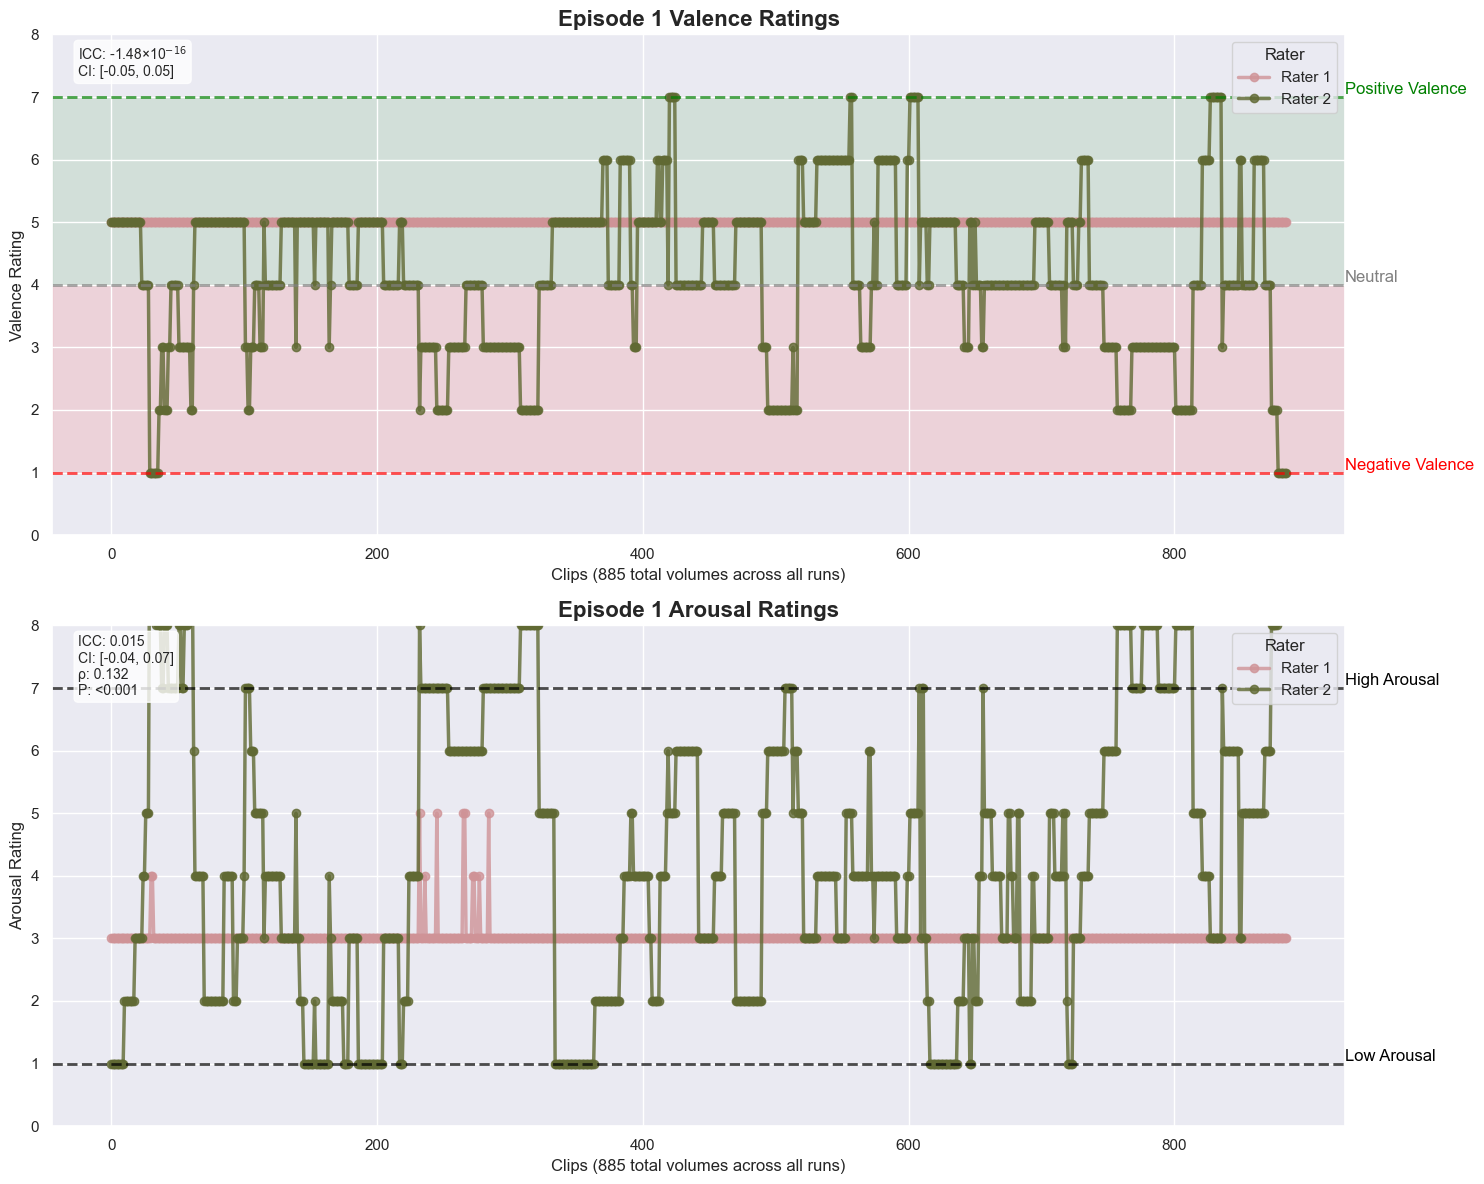

Sequential position range: 0 - 884
Total clips: 885
Number of runs: 3

Processing S01E02
📁 Figure saved: derivatives/figures/episode_02_emotion_ratings.png
📁 Figure saved: derivatives/figures/episode_02_emotion_ratings.png


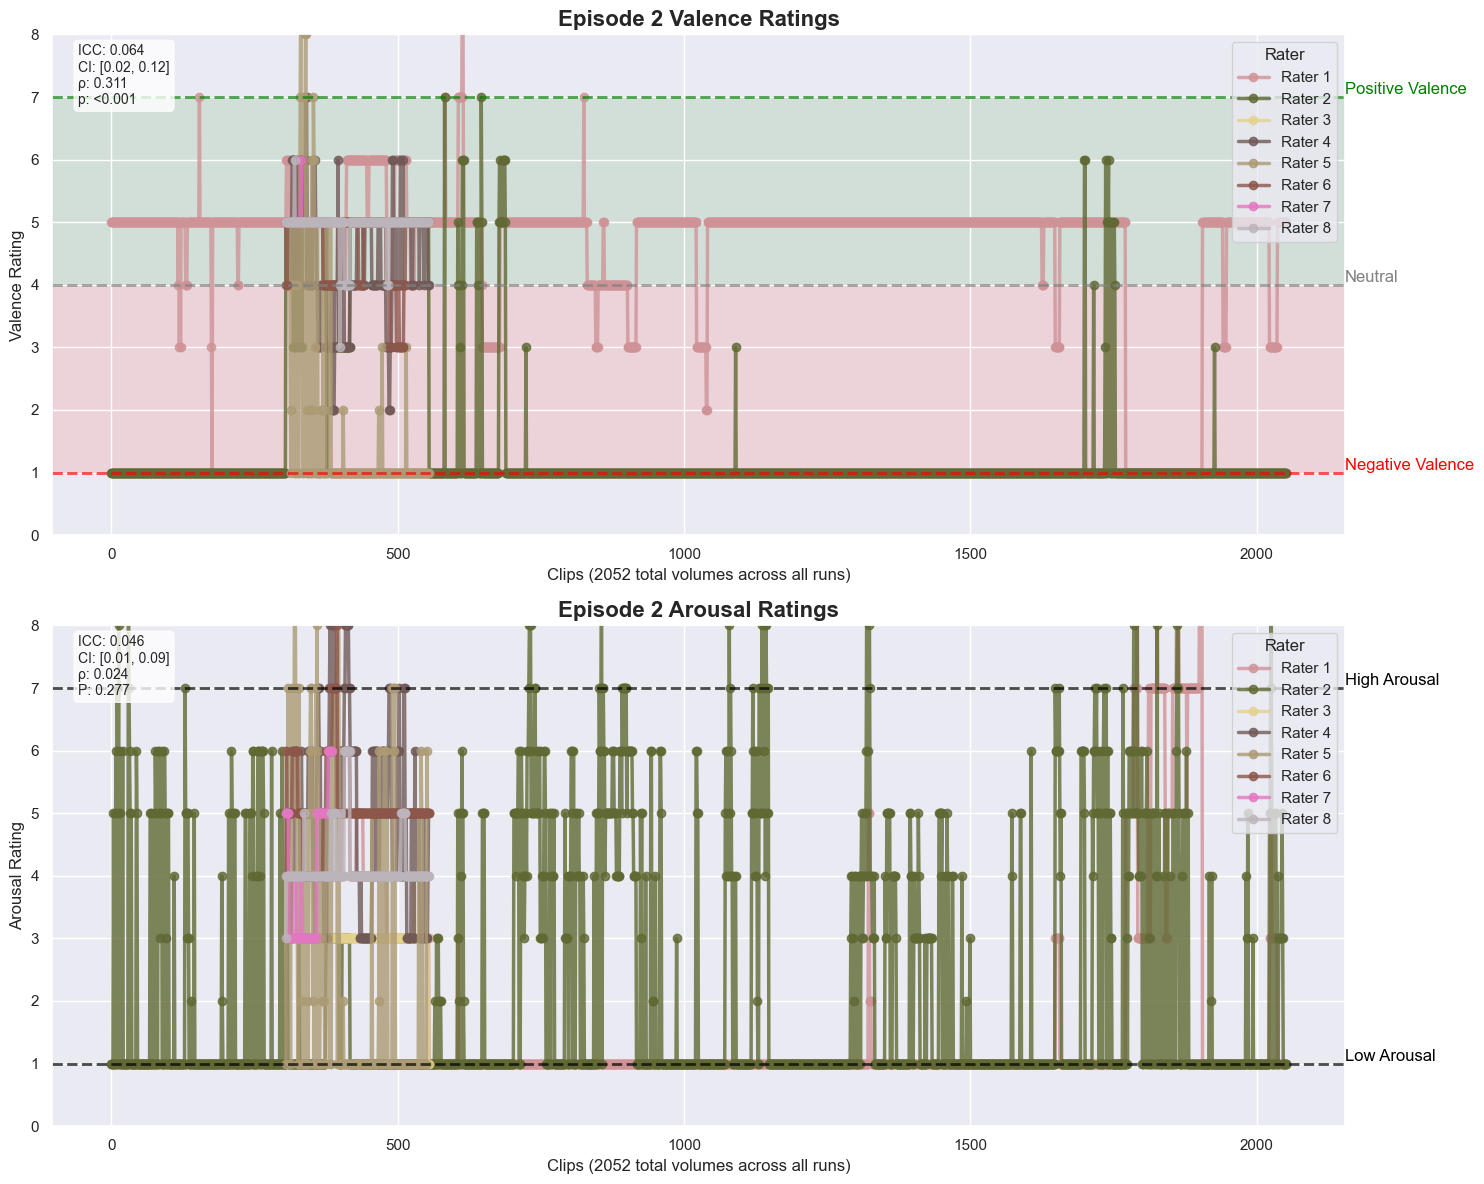

Sequential position range: 0 - 2051
Total clips: 2052
Number of runs: 7

Processing S01E03
📁 Figure saved: derivatives/figures/episode_03_emotion_ratings.png
📁 Figure saved: derivatives/figures/episode_03_emotion_ratings.png


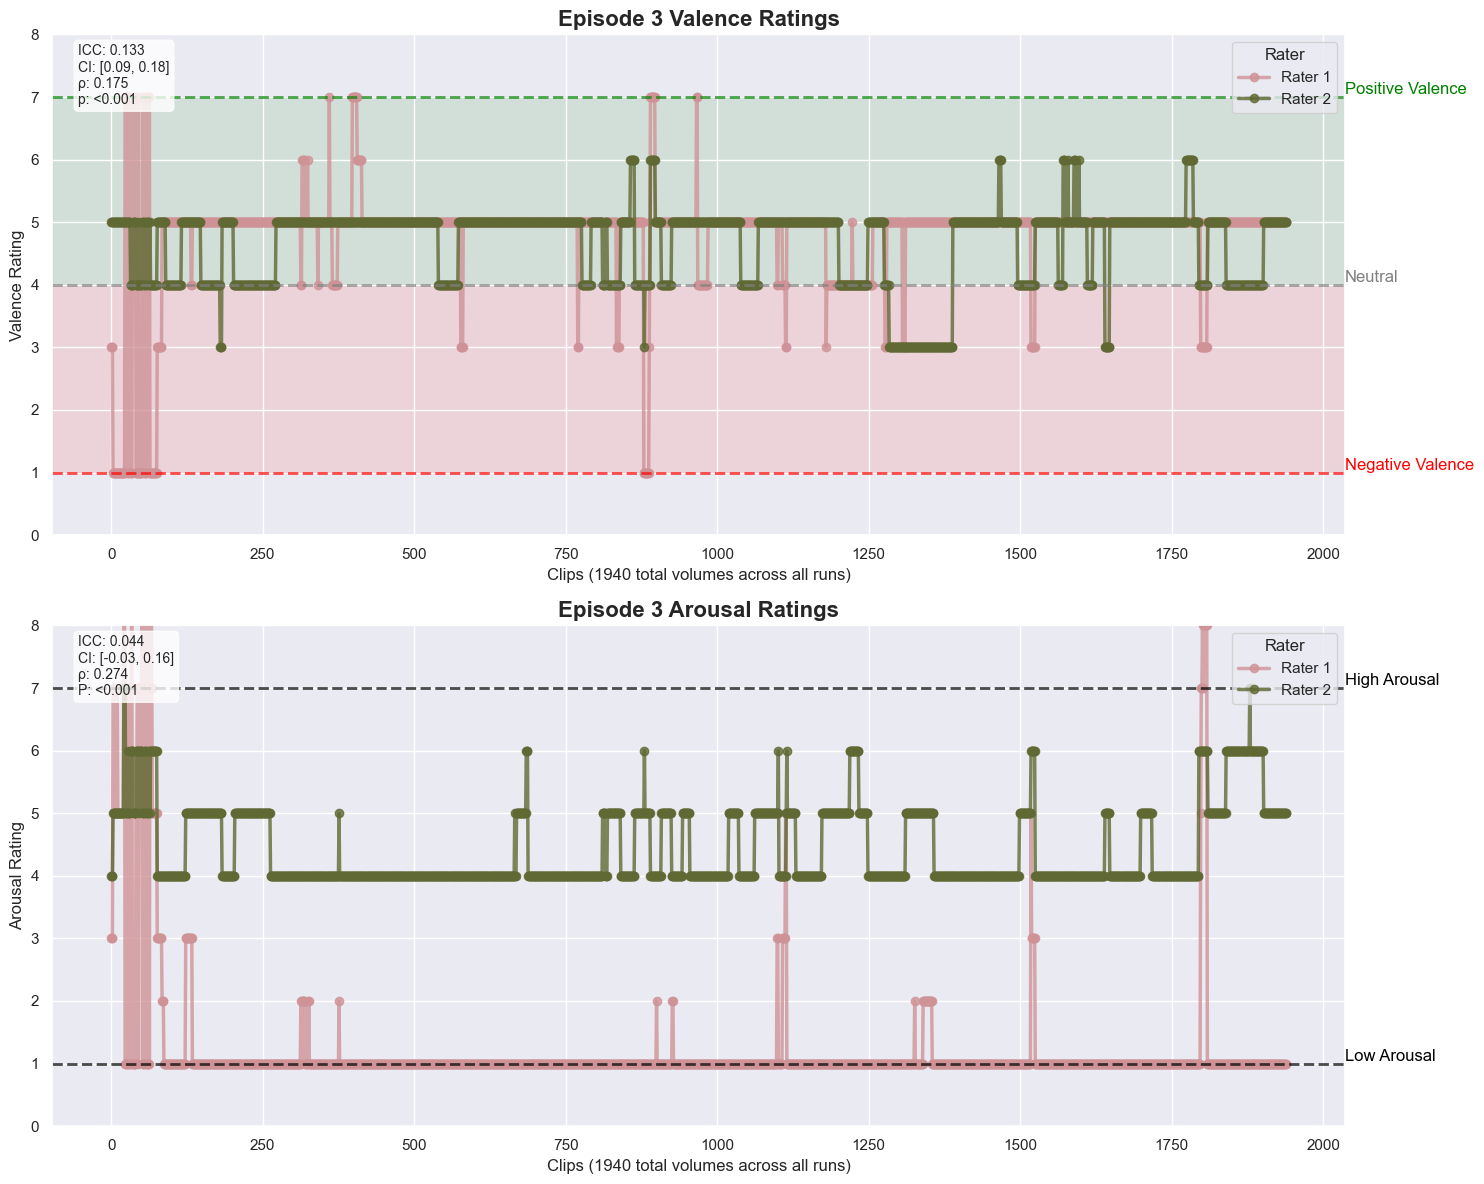

Sequential position range: 0 - 1939
Total clips: 1940
Number of runs: 6

Processing S01E04
📁 Figure saved: derivatives/figures/episode_04_emotion_ratings.png
📁 Figure saved: derivatives/figures/episode_04_emotion_ratings.png


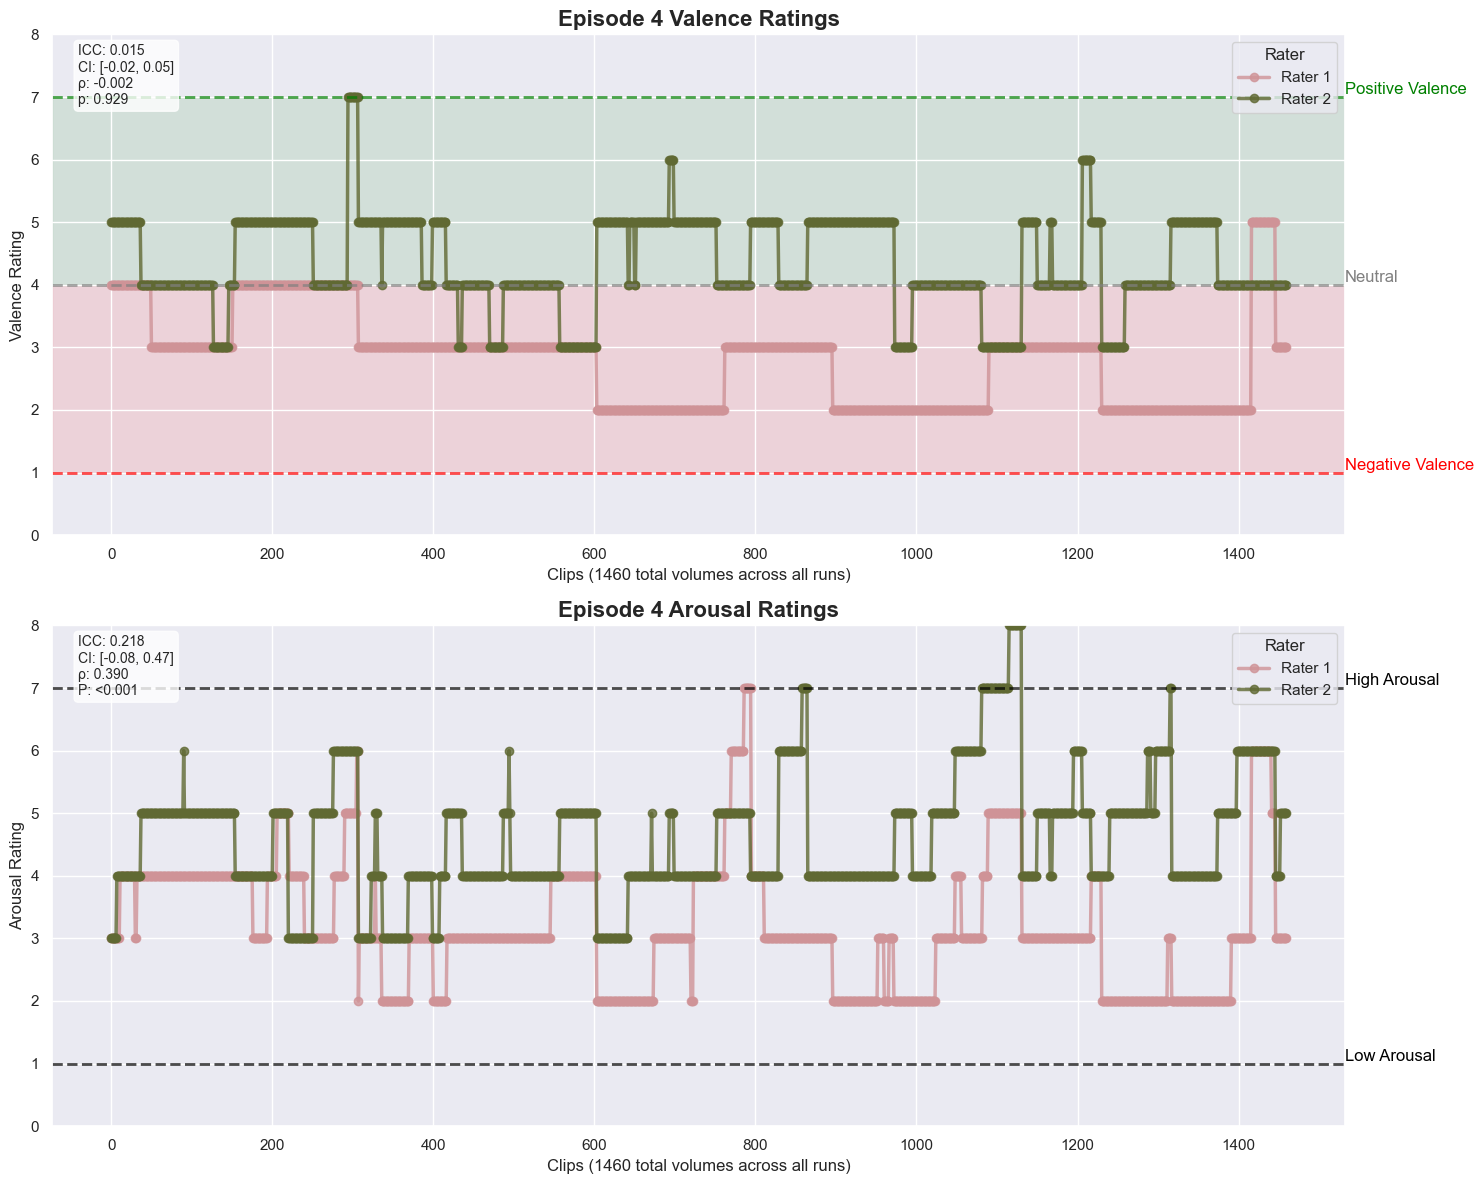

Sequential position range: 0 - 1459
Total clips: 1460
Number of runs: 5

All episode plots completed!


In [4]:
# Episode plotting analysis with statistical results
# Load the overall reliability results
reliability_results = pd.read_csv(OUT_DIR / "interrater_reliability_overall.csv")

episode_numbers = [1,2,3,4]

for ep_num in episode_numbers:
    episode_file = ANNOT_DIR / f"S01E{ep_num:02d}.csv"
    episode_name = Path(episode_file).stem  # e.g., "S01E01"
    print(f"\n{'='*60}")
    print(f"Processing {episode_name}")
    print(f"{'='*60}")
    
    # Load episode data
    episode_df = pd.read_csv(episode_file)
    
    # Find rating columns
    val_cols = [c for c in episode_df.columns if 'valence' in c.lower()]
    aro_cols = [c for c in episode_df.columns if 'arousal' in c.lower()]

    # Extract clip number from 'index' like S01E01R01_clip0007 -> 7
    pattern = rf"{re.escape(episode_name)}R\d{{2}}_clip(\d+)"
    extracted = episode_df['index'].astype(str).str.extract(pattern, expand=False)

    episode_df = episode_df[extracted.notna()].copy()
    episode_df['clip_number'] = extracted[extracted.notna()].astype(int)
    
    # Extract run number (e.g., "S01E01R01" -> 1)
    episode_df['run_number'] = episode_df['run'].str.extract(r'R(\d+)').astype(int)
    
    # Create sequential position: run order first, then clip order within run
    episode_df = episode_df.sort_values(['run_number', 'clip_number'])
    episode_df['sequential_position'] = range(len(episode_df))

    # ---- Make LONG data with rater column ----
    # Valence: columns valence_1, valence_2 -> rows with rater=1/2
    valence_long = episode_df.melt(
        id_vars=['sequential_position', 'run', 'clip_number'],
        value_vars=val_cols,
        var_name='rater',
        value_name='valence'
    )
    valence_long['rater'] = valence_long['rater'].str.extract(r'(\d+)', expand=False).astype(int)

    # Arousal: columns arousal_1, arousal_2 -> rows with rater=1/2
    arousal_long = episode_df.melt(
        id_vars=['sequential_position', 'run', 'clip_number'],
        value_vars=aro_cols,
        var_name='rater',
        value_name='arousal'
    )
    arousal_long['rater'] = arousal_long['rater'].str.extract(r'(\d+)', expand=False).astype(int)

    # ---- Plot ----
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    total_trs = len(episode_df)

    # Valence plot
    if not valence_long.empty:
        ax1.axhspan(1, 4, alpha=0.1, color='red', zorder=0)
        ax1.axhspan(4, 7, alpha=0.1, color='green', zorder=0)

        # Plot each rater separately with explicit colors
        for i, rater in enumerate(sorted(valence_long['rater'].unique())):
            rater_data = valence_long[valence_long['rater'] == rater].sort_values('sequential_position')
            ax1.plot(rater_data['sequential_position'], rater_data['valence'], 
                    color=colors[i % len(colors)], marker='o', markersize=6, linewidth=2.5, 
                    alpha=0.8, label=f'Rater {rater}')
        
        ax1.set_title(f'Episode {ep_num} Valence Ratings', fontsize=16, fontweight='bold')
        ax1.set_xlabel(f'Clips ({total_trs} total volumes across all runs)', fontsize=12)
        ax1.set_ylabel('Valence Rating', fontsize=12)
        ax1.set_ylim(0, 8)
        ax1.legend(title='Rater', loc='upper right')

        # Add reference lines
        ax1.axhline(y=1, color='red', linestyle='--', alpha=0.7, linewidth=2)
        ax1.axhline(y=4, color='gray', linestyle='--', alpha=0.7, linewidth=2)
        ax1.axhline(y=7, color='green', linestyle='--', alpha=0.7, linewidth=2)
        
        # Add text labels
        x_right = ax1.get_xlim()[1]
        ax1.text(x_right, 1, 'Negative Valence', ha='left', va='bottom', fontsize=12, color='red')
        ax1.text(x_right, 4, 'Neutral', ha='left', va='bottom', fontsize=12, color='gray')
        ax1.text(x_right, 7, 'Positive Valence', ha='left', va='bottom', fontsize=12, color='green')
        
        # Add statistical results in top left
        ep_stats = reliability_results[reliability_results['Episode'] == ep_num].iloc[0]
        val_icc = ep_stats['Valence_ICC']
        val_ci_lower = ep_stats['Valence_ICC_CI_Lower']
        val_ci_upper = ep_stats['Valence_ICC_CI_Upper']
        val_spearman = ep_stats['Valence_Spearman_r']
        val_spearman_p = ep_stats['Valence_Spearman_pval']
        
        stats_text = []
        if pd.notna(val_icc):
            # Format ICC with scientific notation if very small
            if abs(val_icc) < 0.001 and val_icc != 0:
                # Convert to scientific notation with proper superscript formatting
                mantissa = val_icc / (10 ** int(np.floor(np.log10(abs(val_icc)))))
                exponent = int(np.floor(np.log10(abs(val_icc))))
                icc_str = f"{mantissa:.2f}×10$^{{{exponent}}}$"
            else:
                icc_str = f"{val_icc:.3f}"
            stats_text.append(f"ICC: {icc_str}")
            if pd.notna(val_ci_lower) and pd.notna(val_ci_upper):
                stats_text.append(f"CI: [{val_ci_lower:.2f}, {val_ci_upper:.2f}]")
        if pd.notna(val_spearman):
            # Format Spearman r with scientific notation if very small
            if abs(val_spearman) < 0.001 and val_spearman != 0:
                # Convert to scientific notation with proper superscript formatting
                mantissa = val_spearman / (10 ** int(np.floor(np.log10(abs(val_spearman)))))
                exponent = int(np.floor(np.log10(abs(val_spearman))))
                spearman_str = f"{mantissa:.2f}×10$^{{{exponent}}}$"
            else:
                spearman_str = f"{val_spearman:.3f}"
            stats_text.append(f"ρ: {spearman_str}")
            if pd.notna(val_spearman_p):
                p_str = f"{val_spearman_p:.3f}" if val_spearman_p >= 0.001 else "<0.001"
                stats_text.append(f"p: {p_str}")
        
        if stats_text:
            ax1.text(0.02, 0.98, '\n'.join(stats_text), transform=ax1.transAxes,
                    fontsize=10, verticalalignment='top', horizontalalignment='left',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    else:
        ax1.set_title('No valence columns found')

    # Arousal plot
    if not arousal_long.empty:
        # Plot each rater separately with explicit colors
        for i, rater in enumerate(sorted(arousal_long['rater'].unique())):
            rater_data = arousal_long[arousal_long['rater'] == rater].sort_values('sequential_position')
            ax2.plot(rater_data['sequential_position'], rater_data['arousal'], 
                    color=colors[i % len(colors)], marker='o', markersize=6, linewidth=2.5, 
                    alpha=0.8, label=f'Rater {rater}')
        
        ax2.set_title(f'Episode {ep_num} Arousal Ratings', fontsize=16, fontweight='bold')
        ax2.set_xlabel(f'Clips ({total_trs} total volumes across all runs)', fontsize=12)
        ax2.set_ylabel('Arousal Rating', fontsize=12)
        ax2.set_ylim(0, 8)
        ax2.legend(title='Rater', loc='upper right')

        # Add reference lines
        ax2.axhline(y=1, color='black', linestyle='--', alpha=0.7, linewidth=2)
        ax2.axhline(y=7, color='black', linestyle='--', alpha=0.7, linewidth=2)
        
        # Add text labels
        x_right = ax2.get_xlim()[1]
        ax2.text(x_right, 1, 'Low Arousal', ha='left', va='bottom', fontsize=12, color='black')
        ax2.text(x_right, 7, 'High Arousal', ha='left', va='bottom', fontsize=12, color='black')
        
        # Add statistical results in top left
        aro_icc = ep_stats['Arousal_ICC']
        aro_ci_lower = ep_stats['Arousal_ICC_CI_Lower']
        aro_ci_upper = ep_stats['Arousal_ICC_CI_Upper']
        aro_spearman = ep_stats['Arousal_Spearman_r']
        aro_spearman_p = ep_stats['Arousal_Spearman_pval']
        
        stats_text = []
        if pd.notna(aro_icc):
            # Format ICC with scientific notation if very small
            if abs(aro_icc) < 0.001 and aro_icc != 0:
                # Convert to scientific notation with proper superscript formatting
                mantissa = aro_icc / (10 ** int(np.floor(np.log10(abs(aro_icc)))))
                exponent = int(np.floor(np.log10(abs(aro_icc))))
                icc_str = f"{mantissa:.2f}×10$^{{{exponent}}}$"
            else:
                icc_str = f"{aro_icc:.3f}"
            stats_text.append(f"ICC: {icc_str}")
            if pd.notna(aro_ci_lower) and pd.notna(aro_ci_upper):
                stats_text.append(f"CI: [{aro_ci_lower:.2f}, {aro_ci_upper:.2f}]")
        if pd.notna(aro_spearman):
            # Format Spearman r with scientific notation if very small
            if abs(aro_spearman) < 0.001 and aro_spearman != 0:
                # Convert to scientific notation with proper superscript formatting
                mantissa = aro_spearman / (10 ** int(np.floor(np.log10(abs(aro_spearman)))))
                exponent = int(np.floor(np.log10(abs(aro_spearman))))
                spearman_str = f"{mantissa:.2f}×10$^{{{exponent}}}$"
            else:
                spearman_str = f"{aro_spearman:.3f}"
            stats_text.append(f"ρ: {spearman_str}")
            if pd.notna(aro_spearman_p):
                p_str = f"{aro_spearman_p:.3f}" if aro_spearman_p >= 0.001 else "<0.001"
                stats_text.append(f"P: {p_str}")
        
        if stats_text:
            ax2.text(0.02, 0.98, '\n'.join(stats_text), transform=ax2.transAxes,
                    fontsize=10, verticalalignment='top', horizontalalignment='left',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    else:
        ax2.set_title('No arousal columns found')

    plt.tight_layout()
    
    # Save figure with 300 DPI
    figure_filename = f"episode_{ep_num:02d}_emotion_ratings.png"
    figure_path = FIGURES_DIR / figure_filename
    fig.savefig(figure_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"📁 Figure saved: {figure_path}")
    
    plt.show()

    print(f"Sequential position range: 0 - {len(episode_df)-1}")
    print(f"Total clips: {len(episode_df)}")
    print(f"Number of runs: {episode_df['run_number'].nunique()}")

print(f"\n{'='*60}")
print("All episode plots completed!")
print(f"{'='*60}")


Creating individual run plots for S01E01
  Creating plot for Run 1 (334 clips)
  Creating plot for Run 1 (334 clips)
    📁 Figure saved: derivatives/figures/episode_01_run_01_emotion_ratings.png
    📁 Figure saved: derivatives/figures/episode_01_run_01_emotion_ratings.png


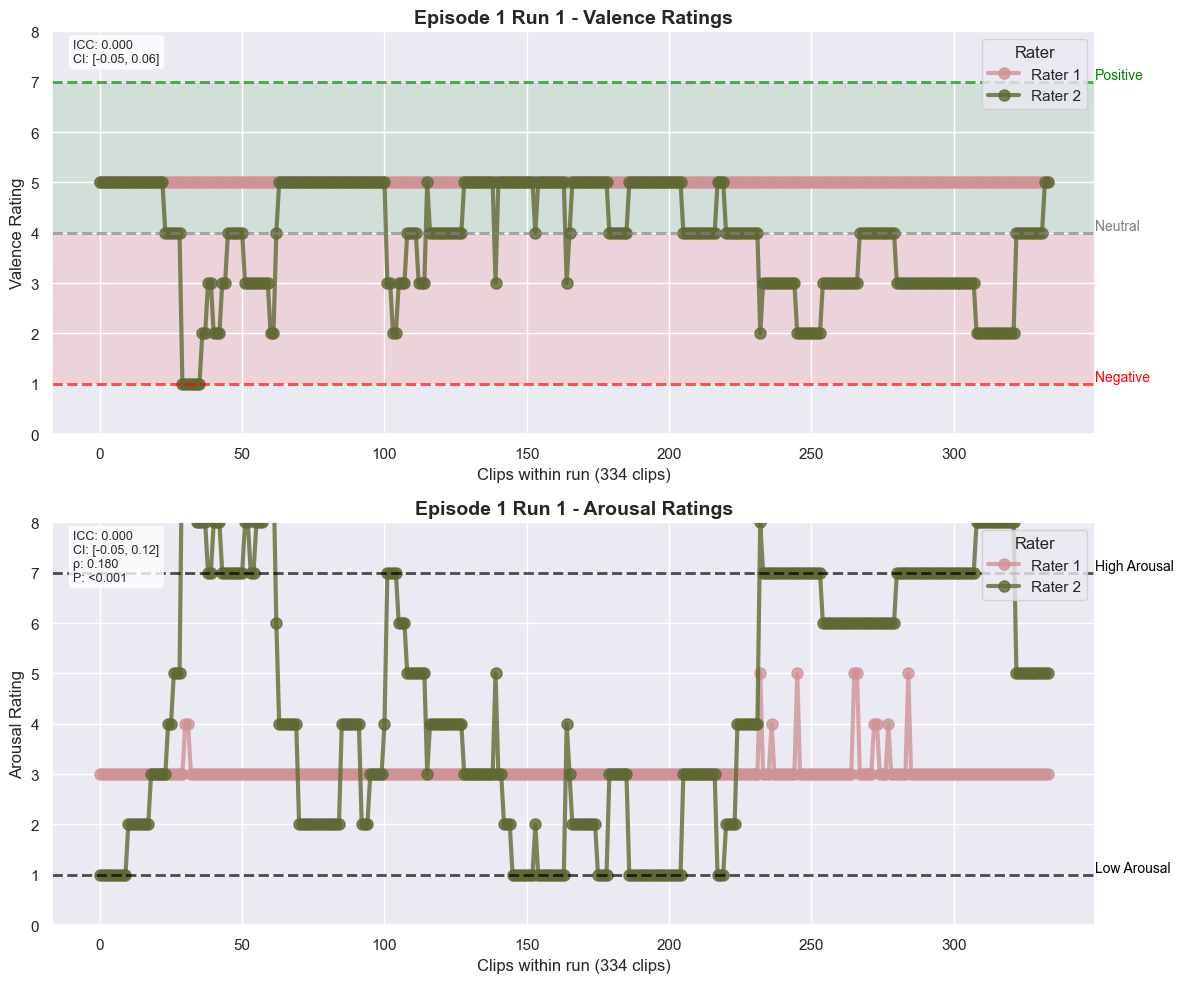

  Creating plot for Run 2 (276 clips)
    📁 Figure saved: derivatives/figures/episode_01_run_02_emotion_ratings.png
    📁 Figure saved: derivatives/figures/episode_01_run_02_emotion_ratings.png


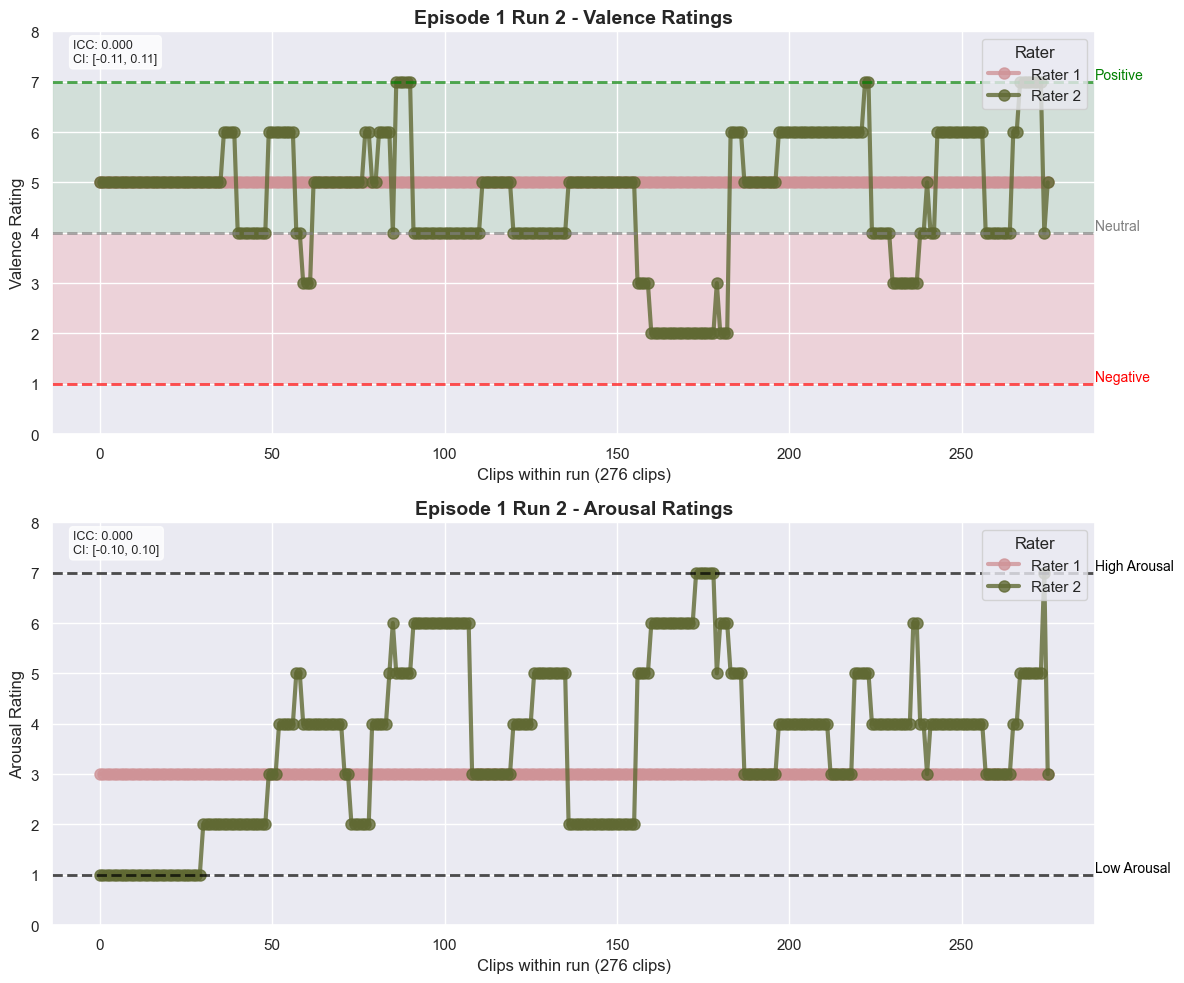

  Creating plot for Run 3 (275 clips)
    📁 Figure saved: derivatives/figures/episode_01_run_03_emotion_ratings.png
    📁 Figure saved: derivatives/figures/episode_01_run_03_emotion_ratings.png


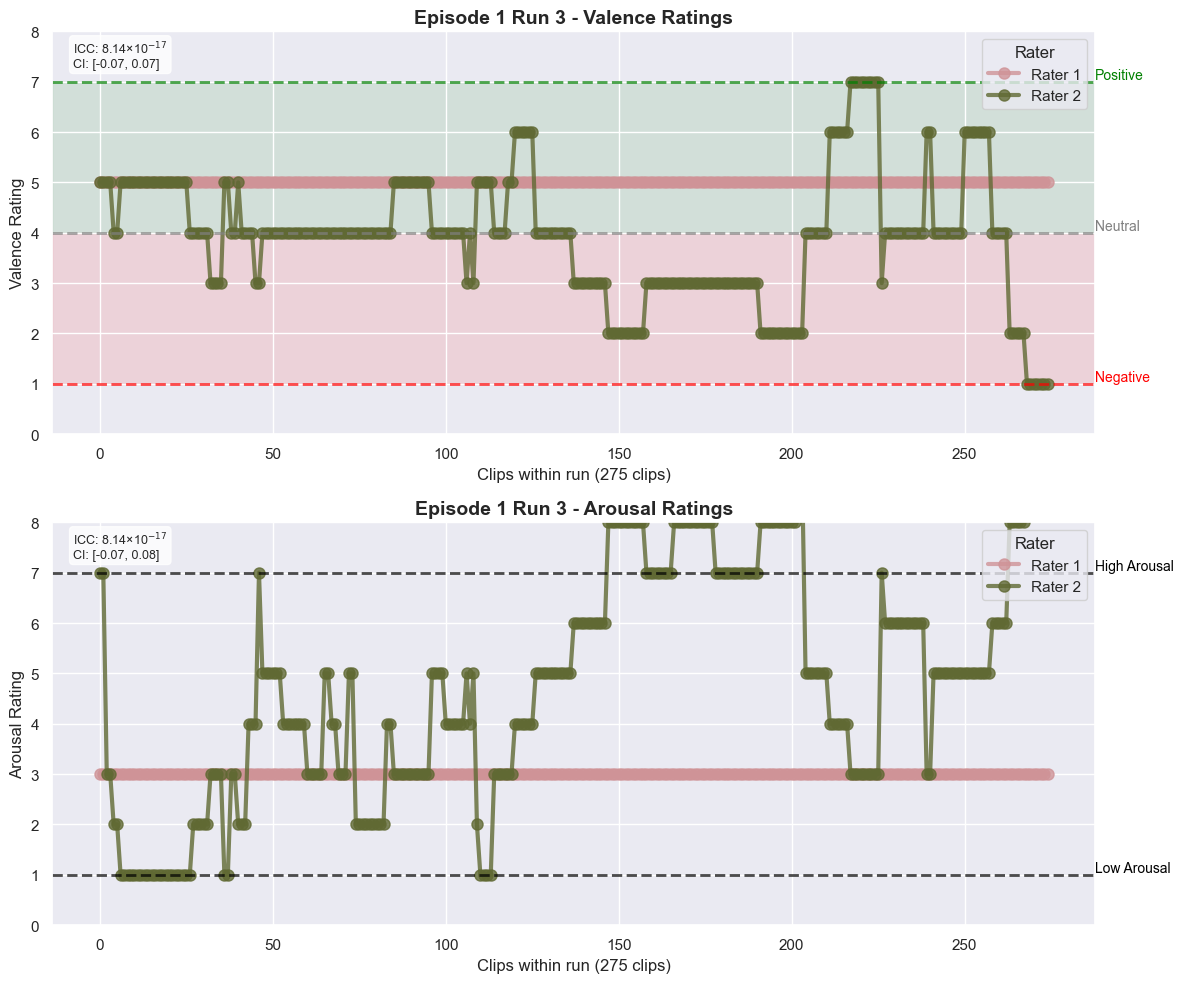


Creating individual run plots for S01E02
  Creating plot for Run 1 (305 clips)
    📁 Figure saved: derivatives/figures/episode_02_run_01_emotion_ratings.png
    📁 Figure saved: derivatives/figures/episode_02_run_01_emotion_ratings.png


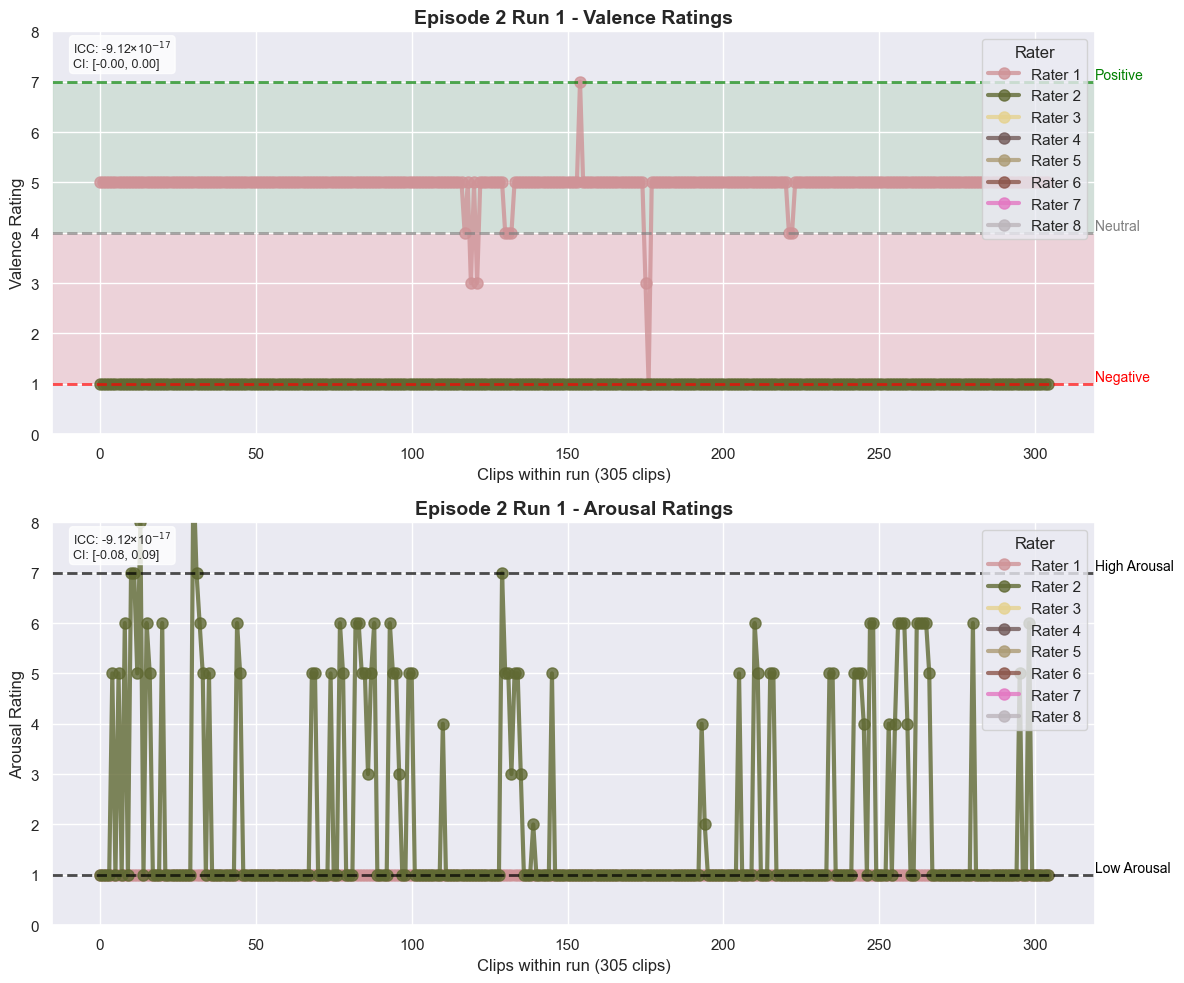

  Creating plot for Run 2 (250 clips)
    📁 Figure saved: derivatives/figures/episode_02_run_02_emotion_ratings.png
    📁 Figure saved: derivatives/figures/episode_02_run_02_emotion_ratings.png


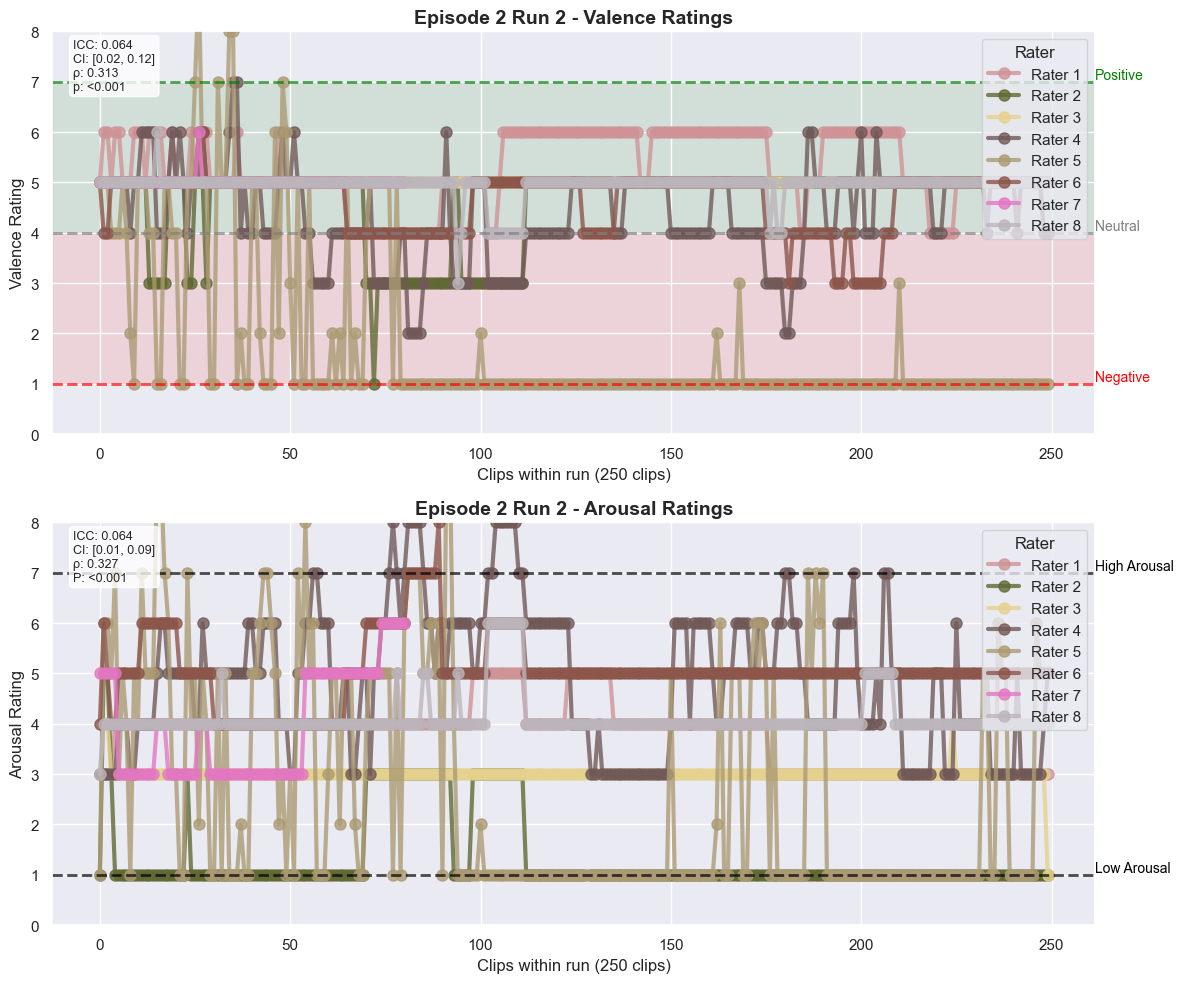

  Creating plot for Run 3 (362 clips)
    📁 Figure saved: derivatives/figures/episode_02_run_03_emotion_ratings.png
    📁 Figure saved: derivatives/figures/episode_02_run_03_emotion_ratings.png


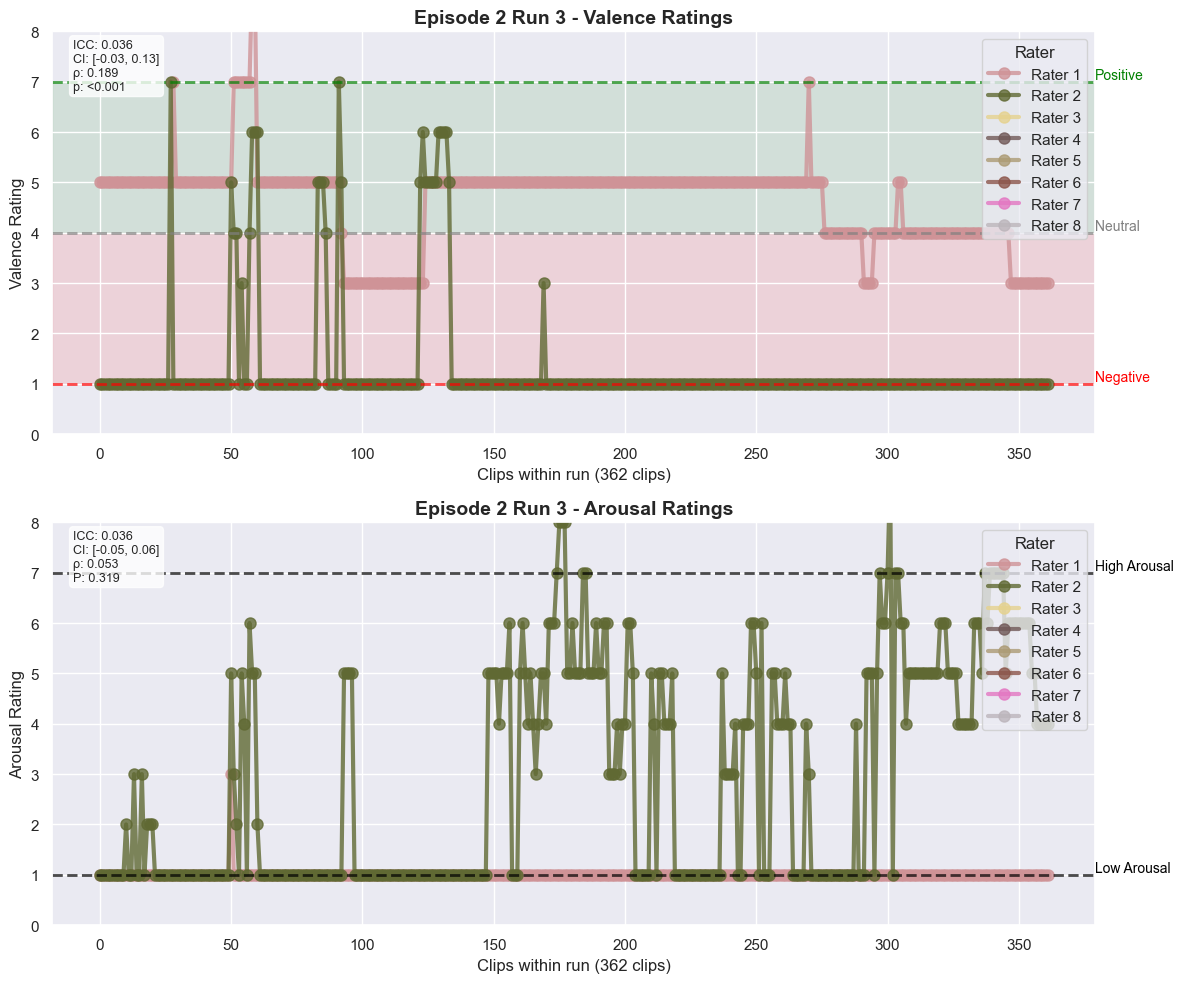

  Creating plot for Run 4 (354 clips)
    📁 Figure saved: derivatives/figures/episode_02_run_04_emotion_ratings.png
    📁 Figure saved: derivatives/figures/episode_02_run_04_emotion_ratings.png


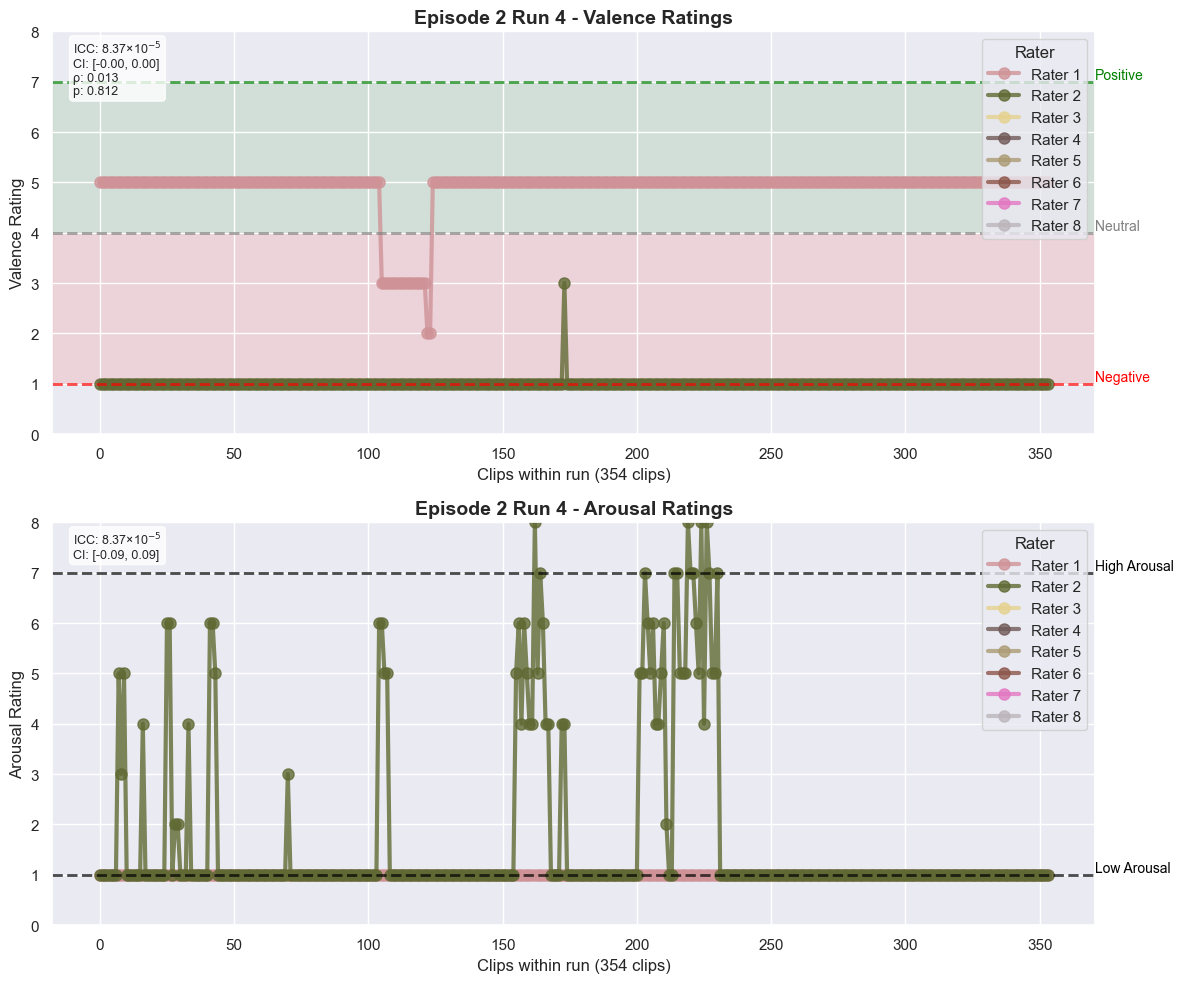

  Creating plot for Run 5 (295 clips)
    📁 Figure saved: derivatives/figures/episode_02_run_05_emotion_ratings.png
    📁 Figure saved: derivatives/figures/episode_02_run_05_emotion_ratings.png


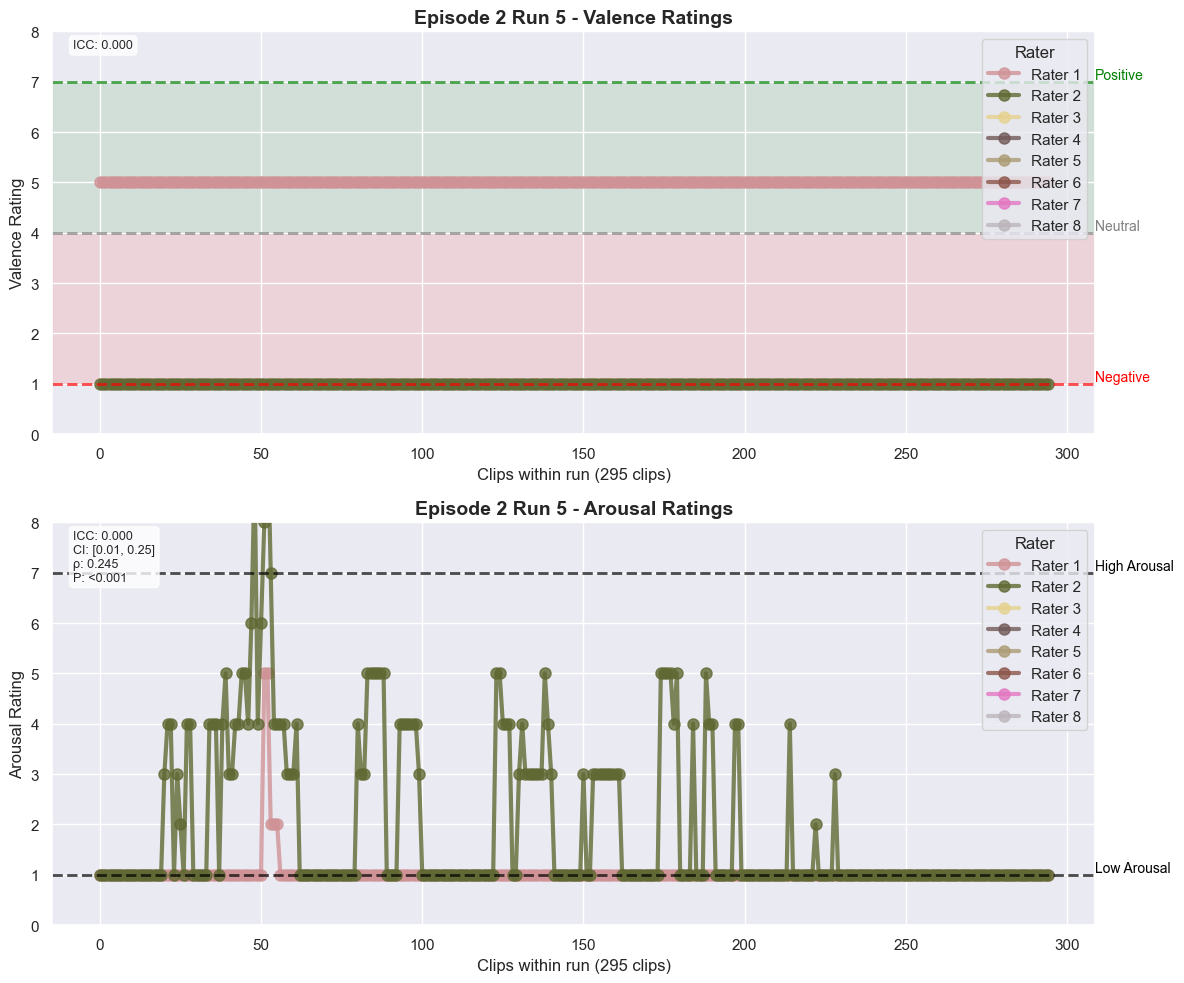

  Creating plot for Run 6 (192 clips)
    📁 Figure saved: derivatives/figures/episode_02_run_06_emotion_ratings.png
    📁 Figure saved: derivatives/figures/episode_02_run_06_emotion_ratings.png


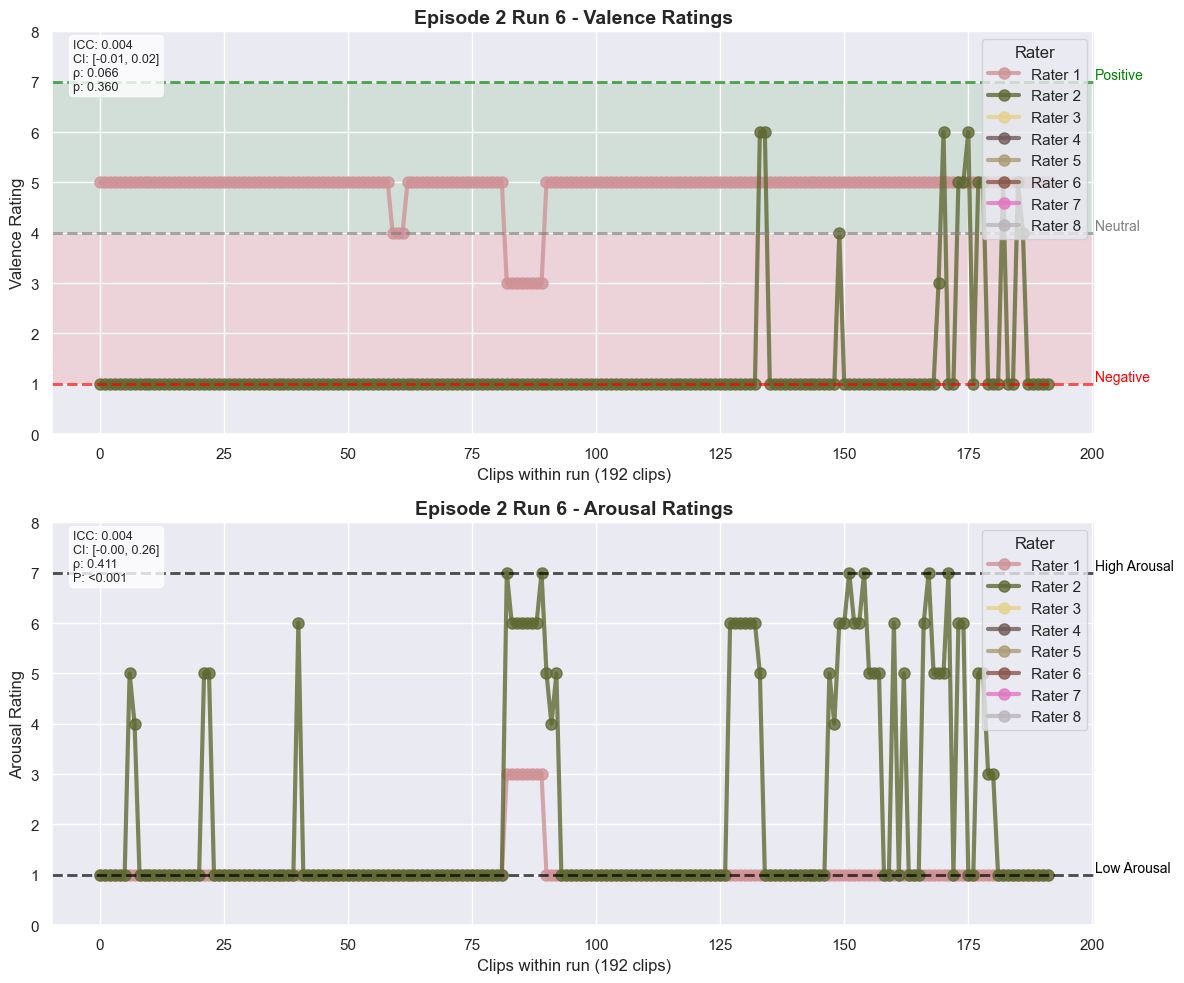

  Creating plot for Run 7 (294 clips)
    📁 Figure saved: derivatives/figures/episode_02_run_07_emotion_ratings.png
    📁 Figure saved: derivatives/figures/episode_02_run_07_emotion_ratings.png


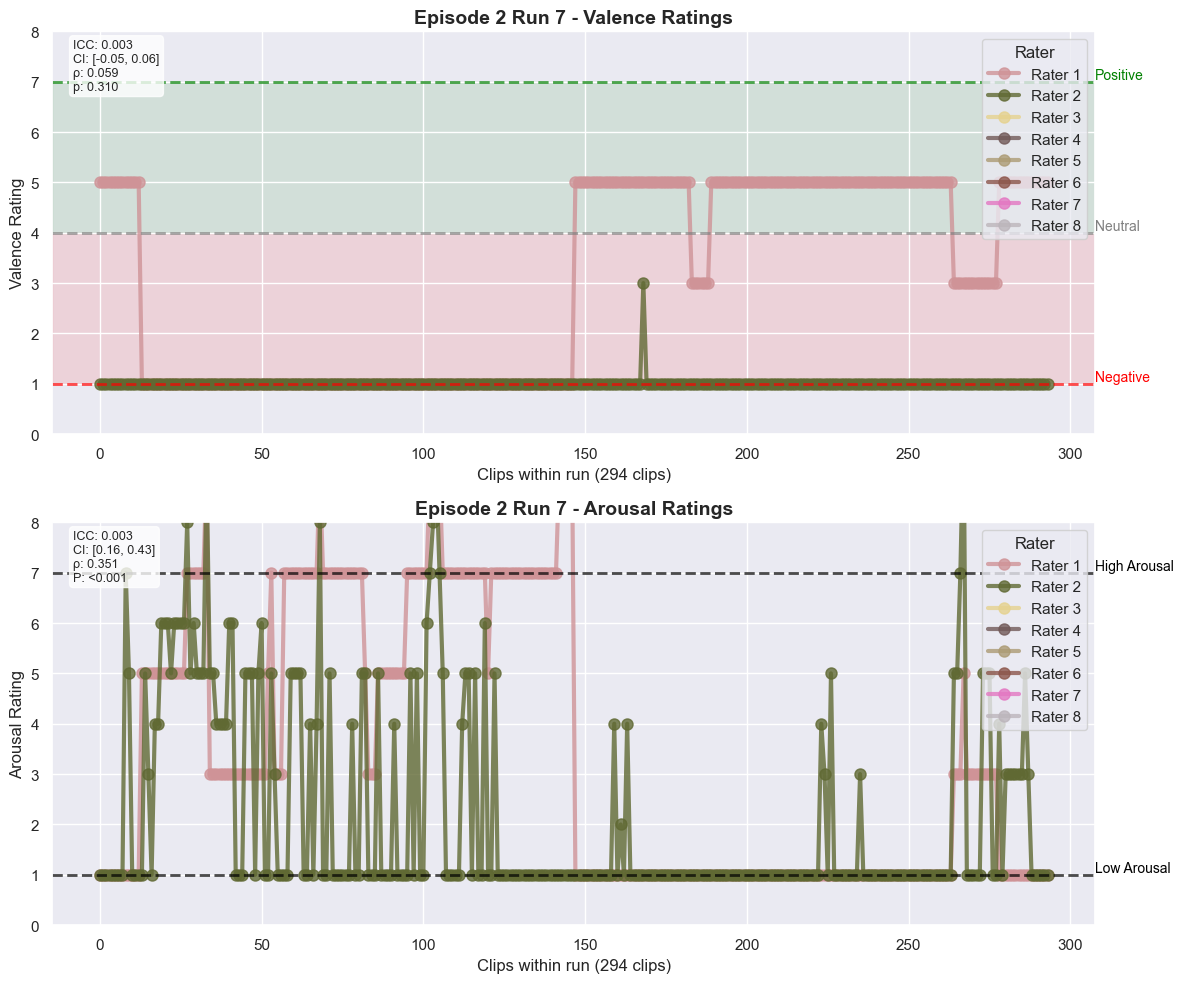


Creating individual run plots for S01E03
  Creating plot for Run 1 (272 clips)
  Creating plot for Run 1 (272 clips)
    📁 Figure saved: derivatives/figures/episode_03_run_01_emotion_ratings.png
    📁 Figure saved: derivatives/figures/episode_03_run_01_emotion_ratings.png


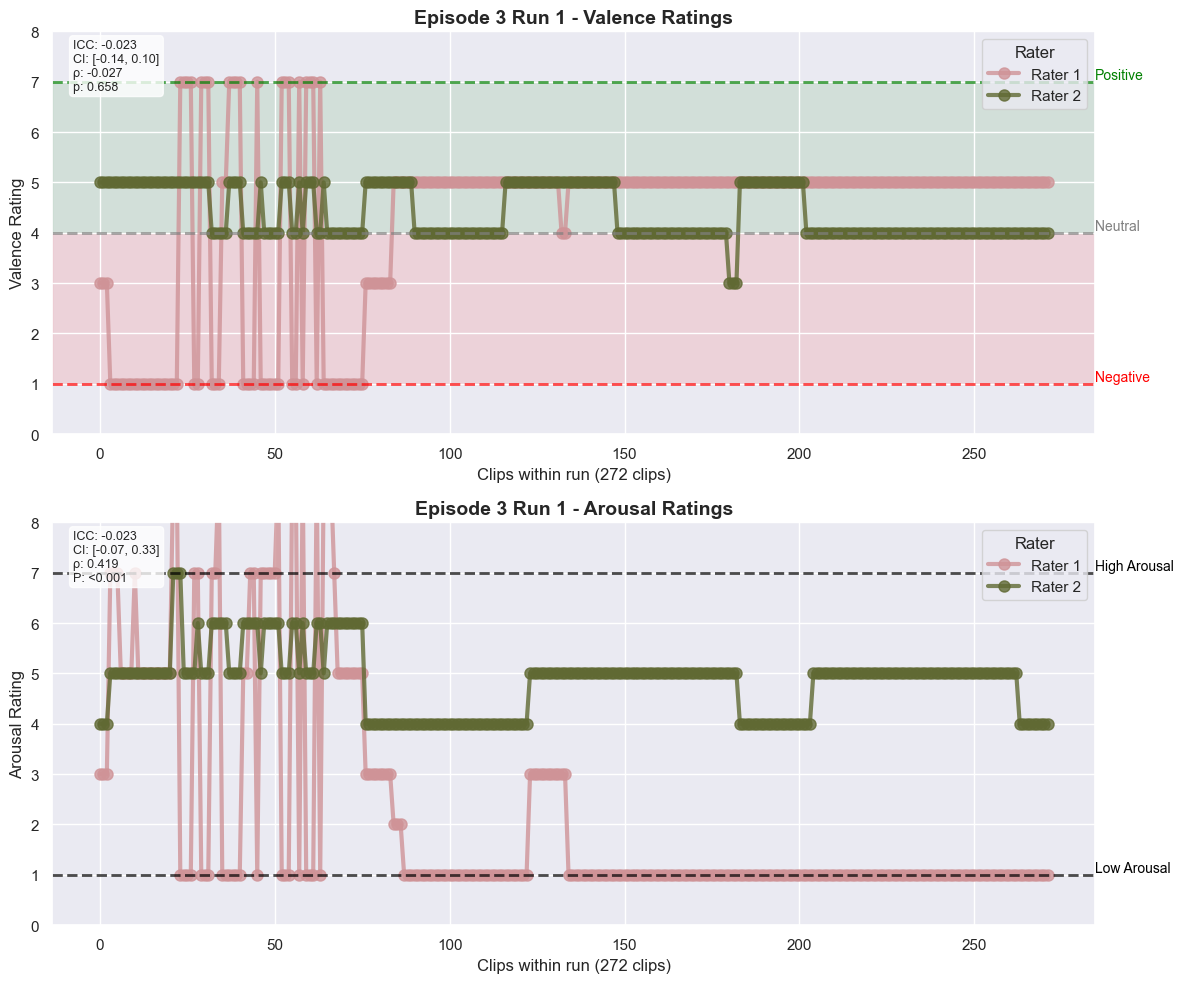

  Creating plot for Run 2 (309 clips)
    📁 Figure saved: derivatives/figures/episode_03_run_02_emotion_ratings.png
    📁 Figure saved: derivatives/figures/episode_03_run_02_emotion_ratings.png


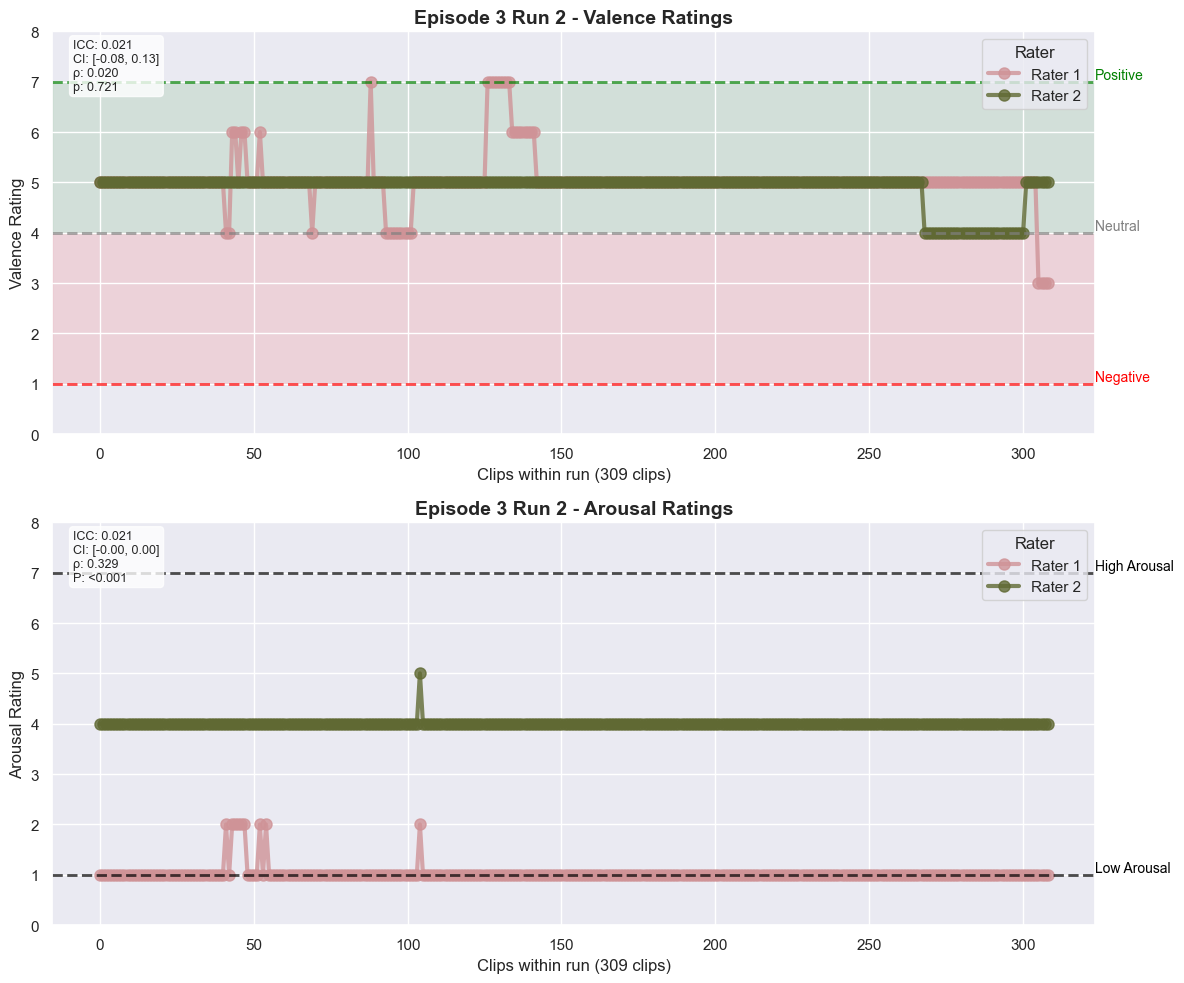

  Creating plot for Run 3 (317 clips)
    📁 Figure saved: derivatives/figures/episode_03_run_03_emotion_ratings.png
    📁 Figure saved: derivatives/figures/episode_03_run_03_emotion_ratings.png


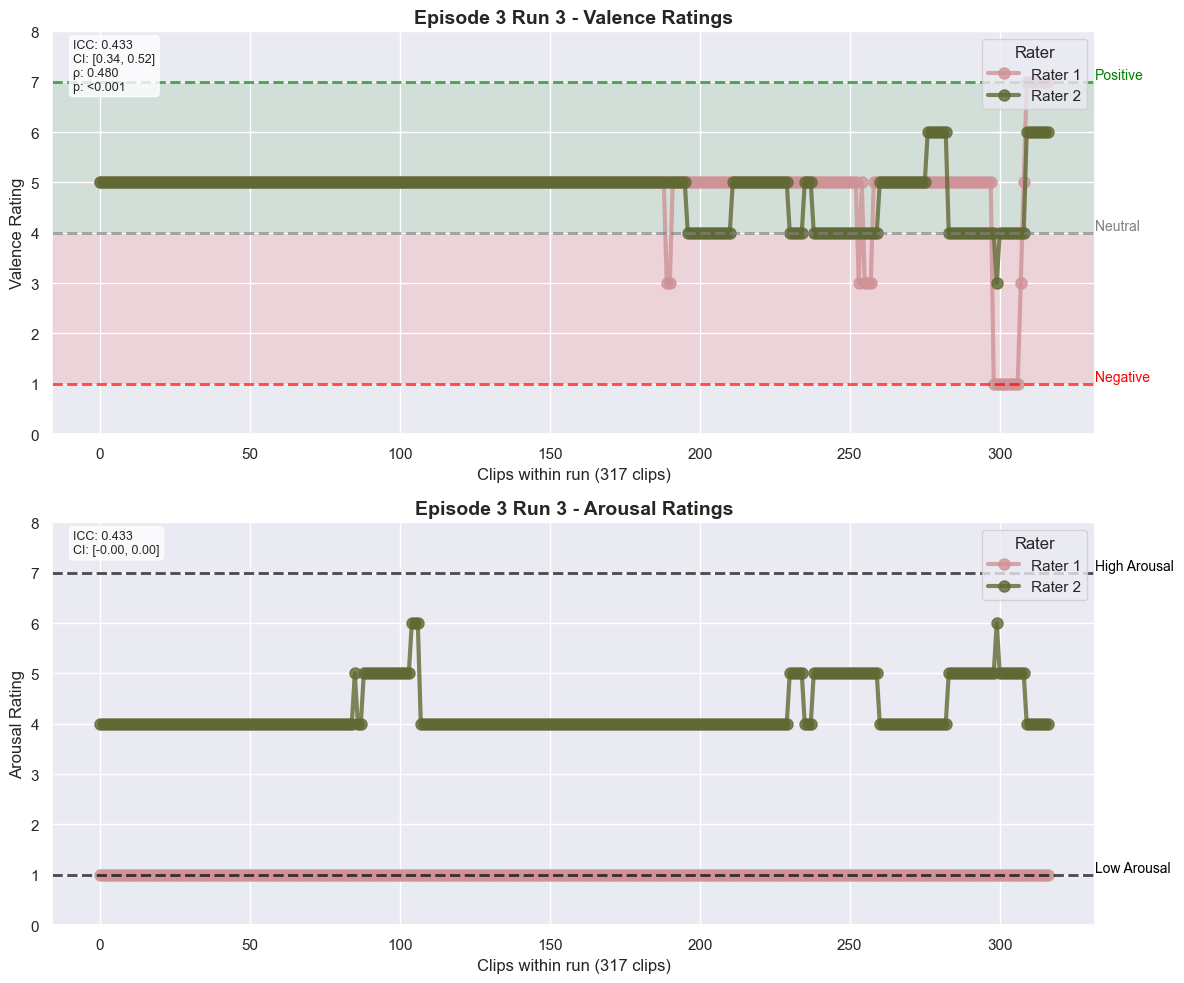

  Creating plot for Run 4 (359 clips)
    📁 Figure saved: derivatives/figures/episode_03_run_04_emotion_ratings.png
    📁 Figure saved: derivatives/figures/episode_03_run_04_emotion_ratings.png


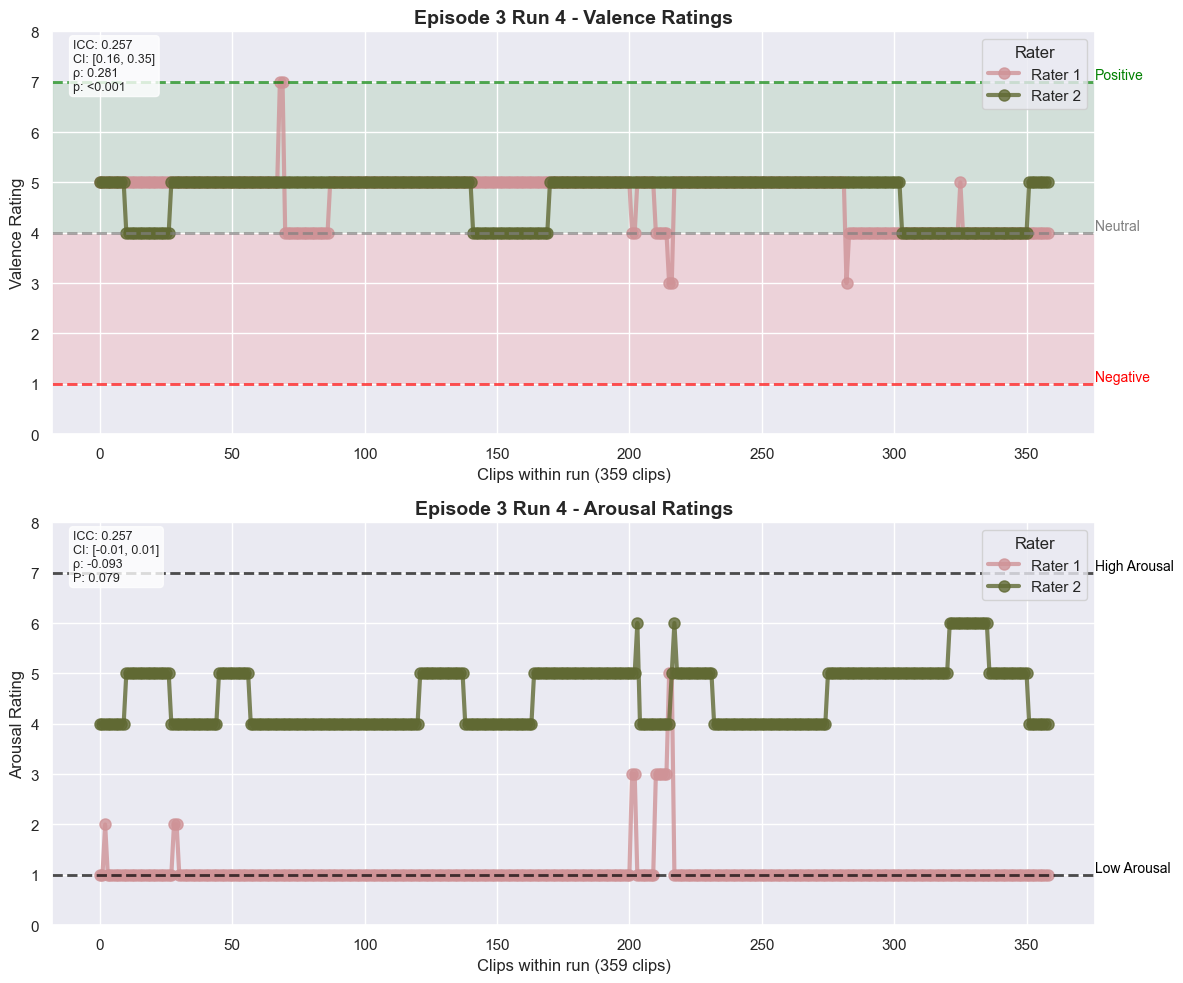

  Creating plot for Run 5 (268 clips)
    📁 Figure saved: derivatives/figures/episode_03_run_05_emotion_ratings.png
    📁 Figure saved: derivatives/figures/episode_03_run_05_emotion_ratings.png


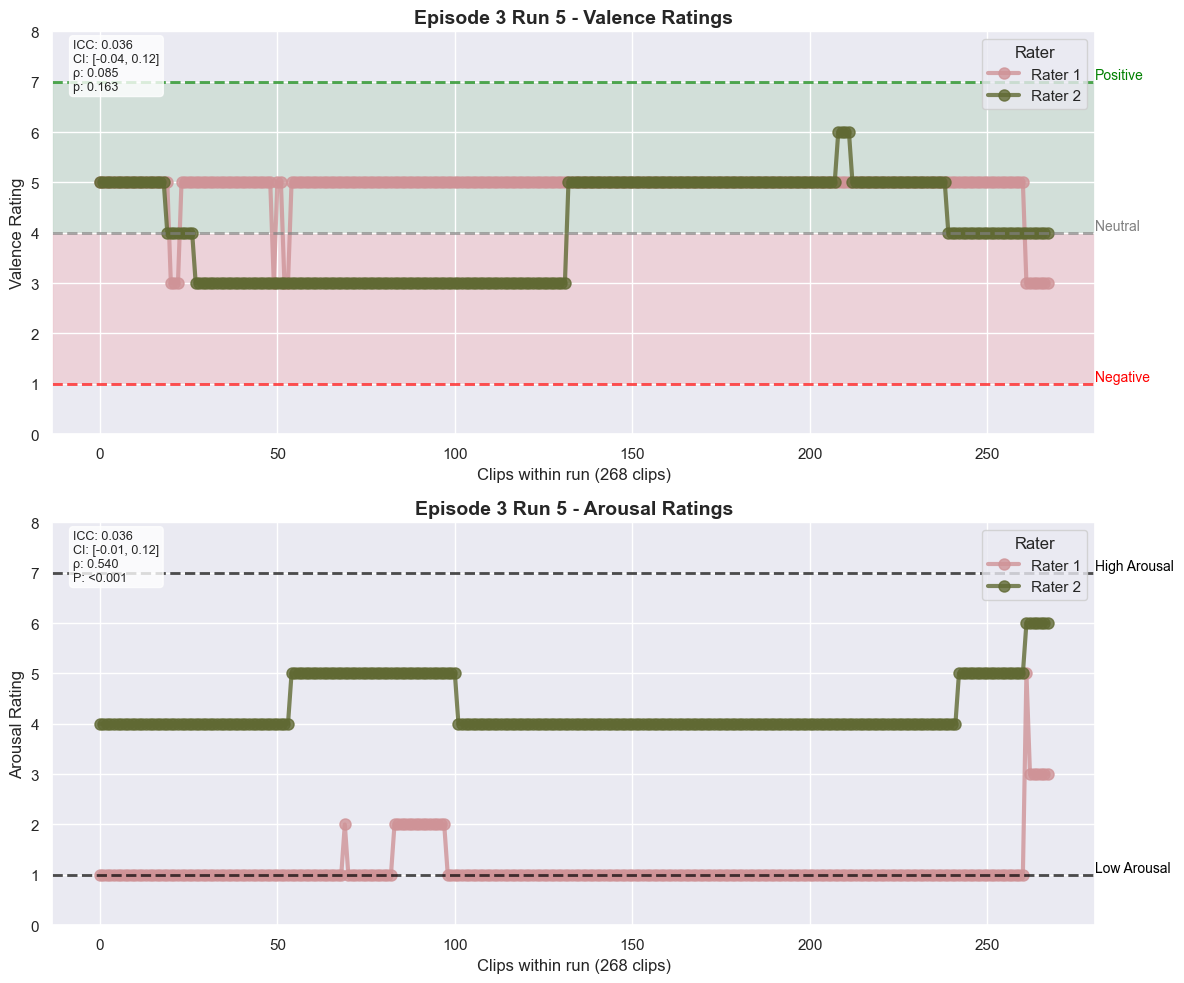

  Creating plot for Run 6 (415 clips)
    📁 Figure saved: derivatives/figures/episode_03_run_06_emotion_ratings.png
    📁 Figure saved: derivatives/figures/episode_03_run_06_emotion_ratings.png


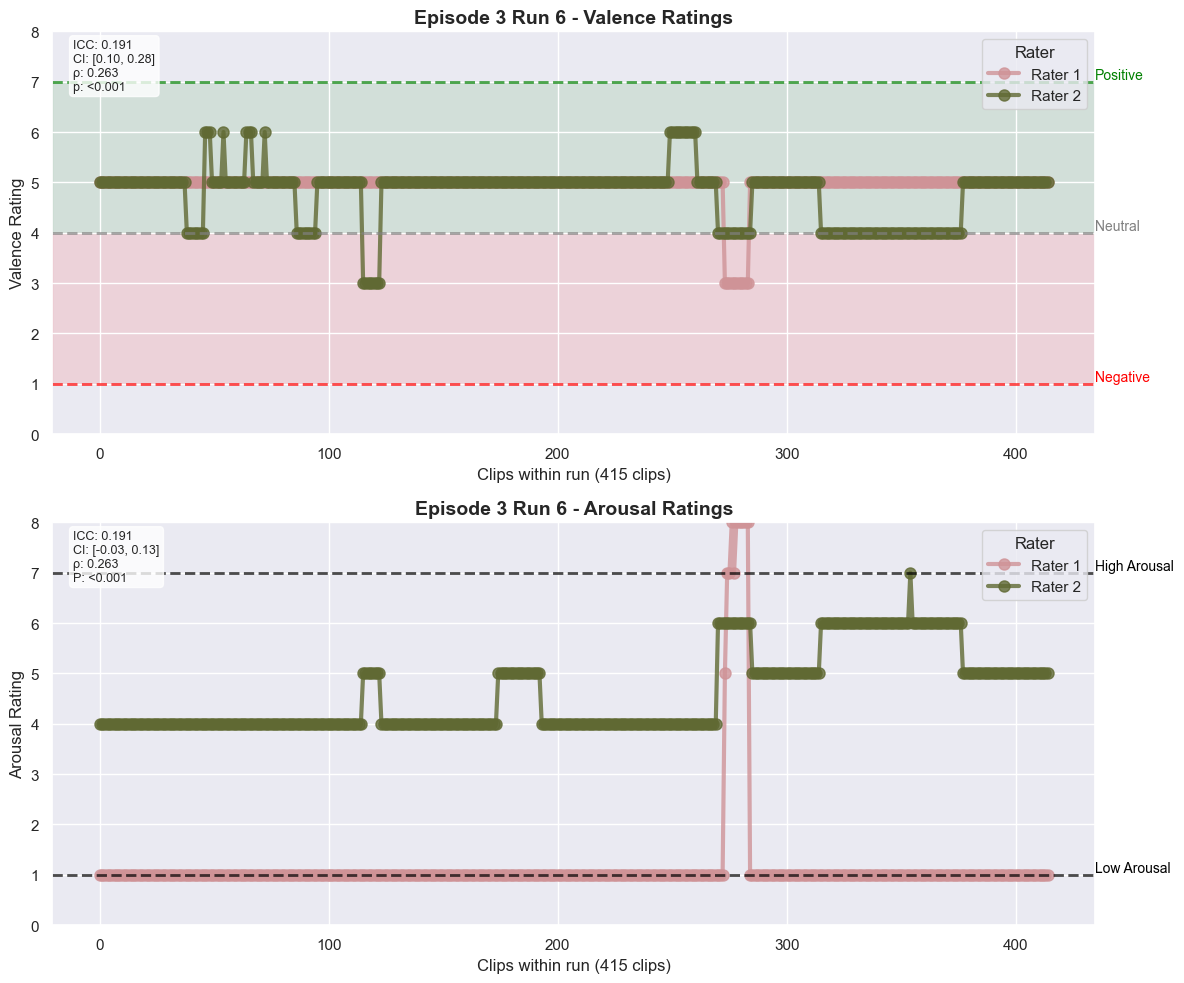


Creating individual run plots for S01E04
  Creating plot for Run 1 (307 clips)
    📁 Figure saved: derivatives/figures/episode_04_run_01_emotion_ratings.png
    📁 Figure saved: derivatives/figures/episode_04_run_01_emotion_ratings.png


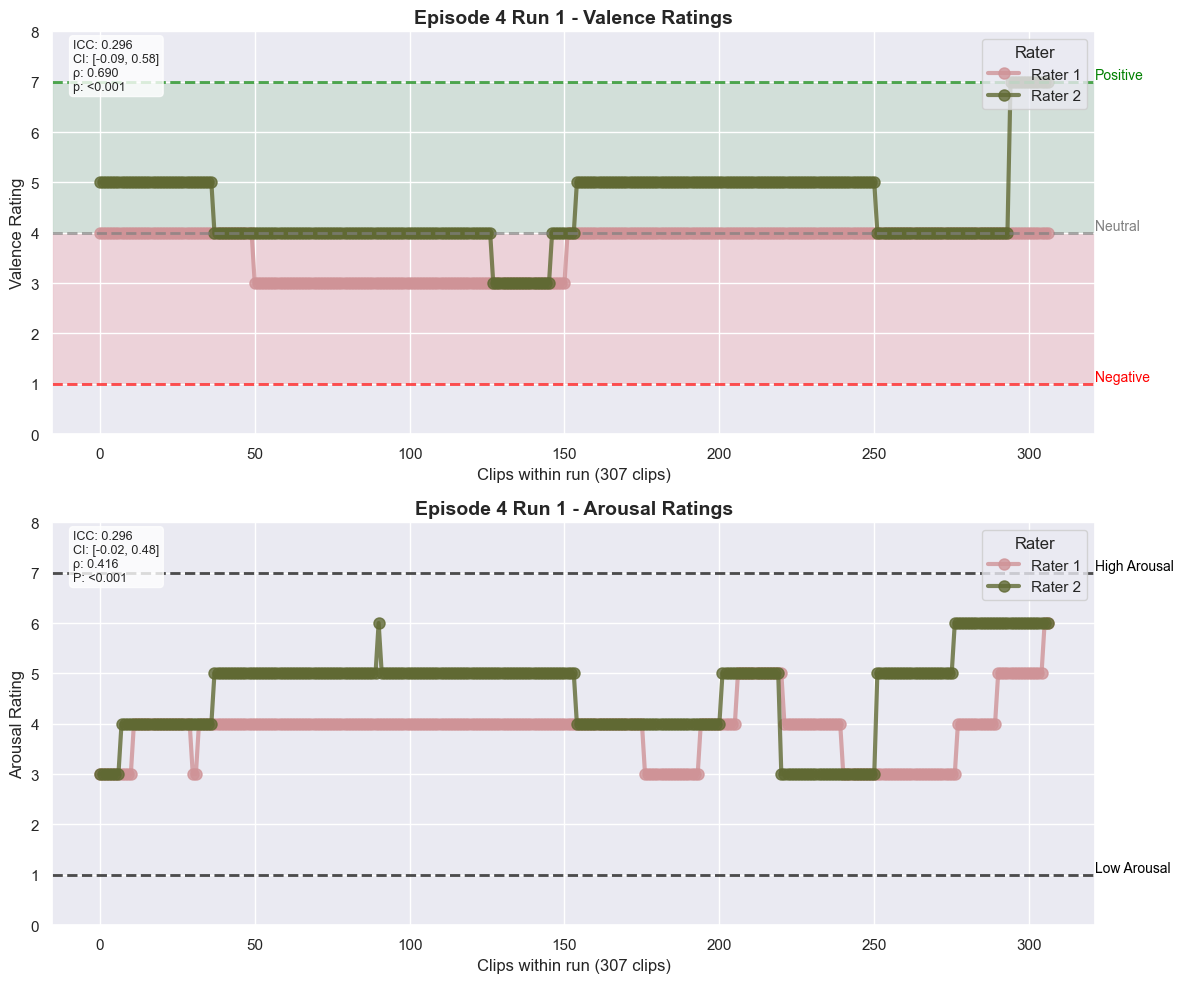

  Creating plot for Run 2 (296 clips)
    📁 Figure saved: derivatives/figures/episode_04_run_02_emotion_ratings.png
    📁 Figure saved: derivatives/figures/episode_04_run_02_emotion_ratings.png


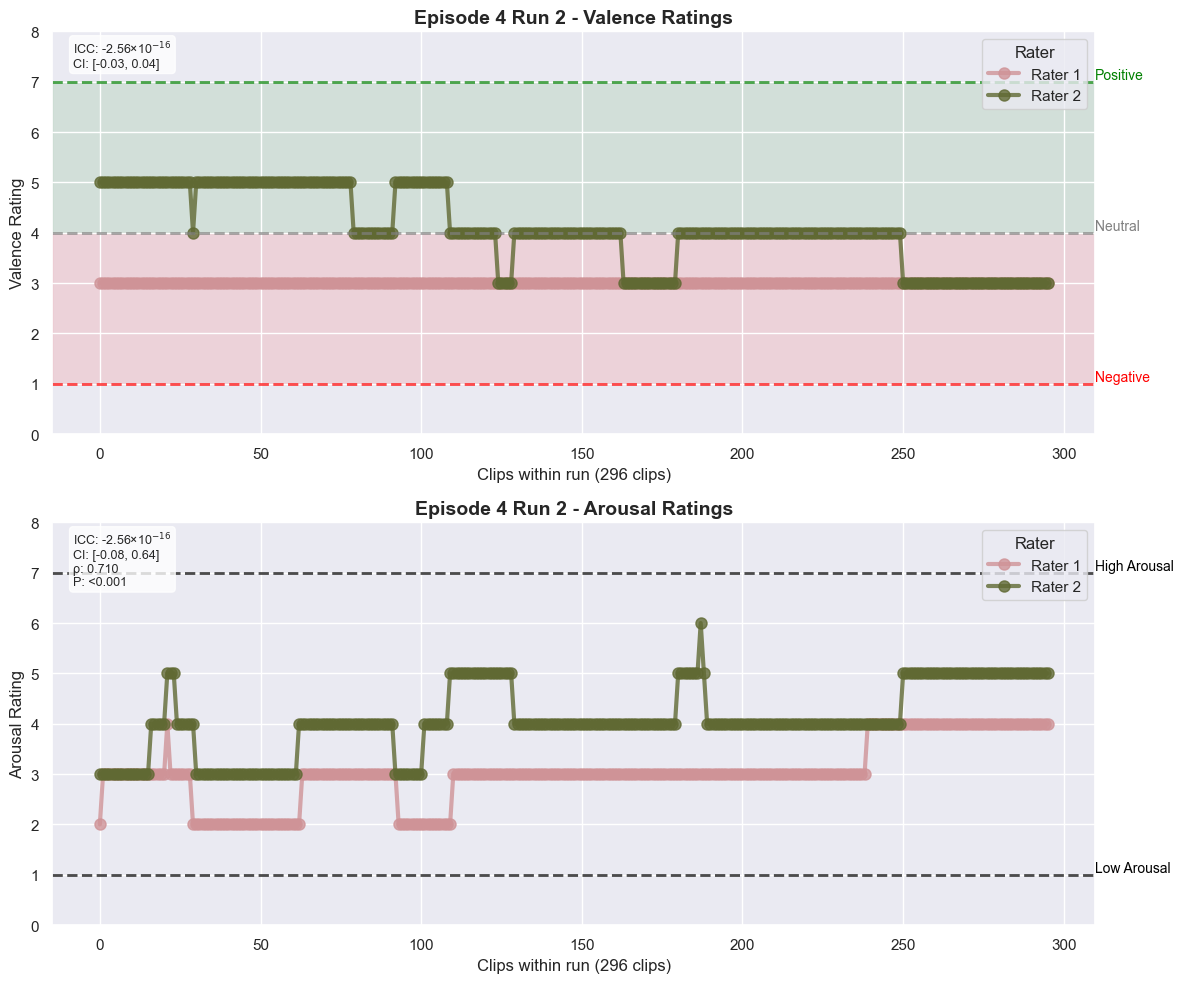

  Creating plot for Run 3 (293 clips)
    📁 Figure saved: derivatives/figures/episode_04_run_03_emotion_ratings.png
    📁 Figure saved: derivatives/figures/episode_04_run_03_emotion_ratings.png


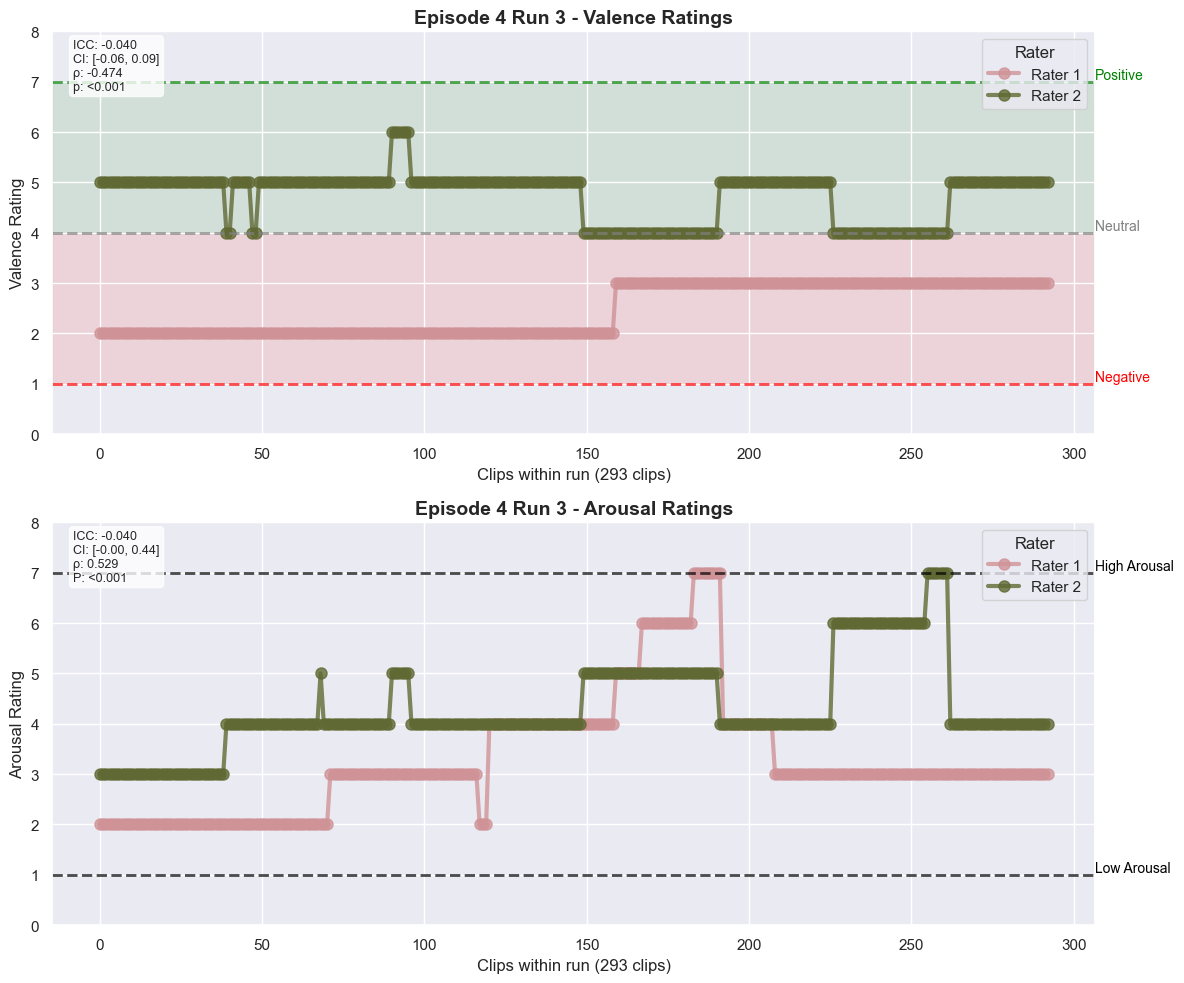

  Creating plot for Run 4 (334 clips)
    📁 Figure saved: derivatives/figures/episode_04_run_04_emotion_ratings.png
    📁 Figure saved: derivatives/figures/episode_04_run_04_emotion_ratings.png


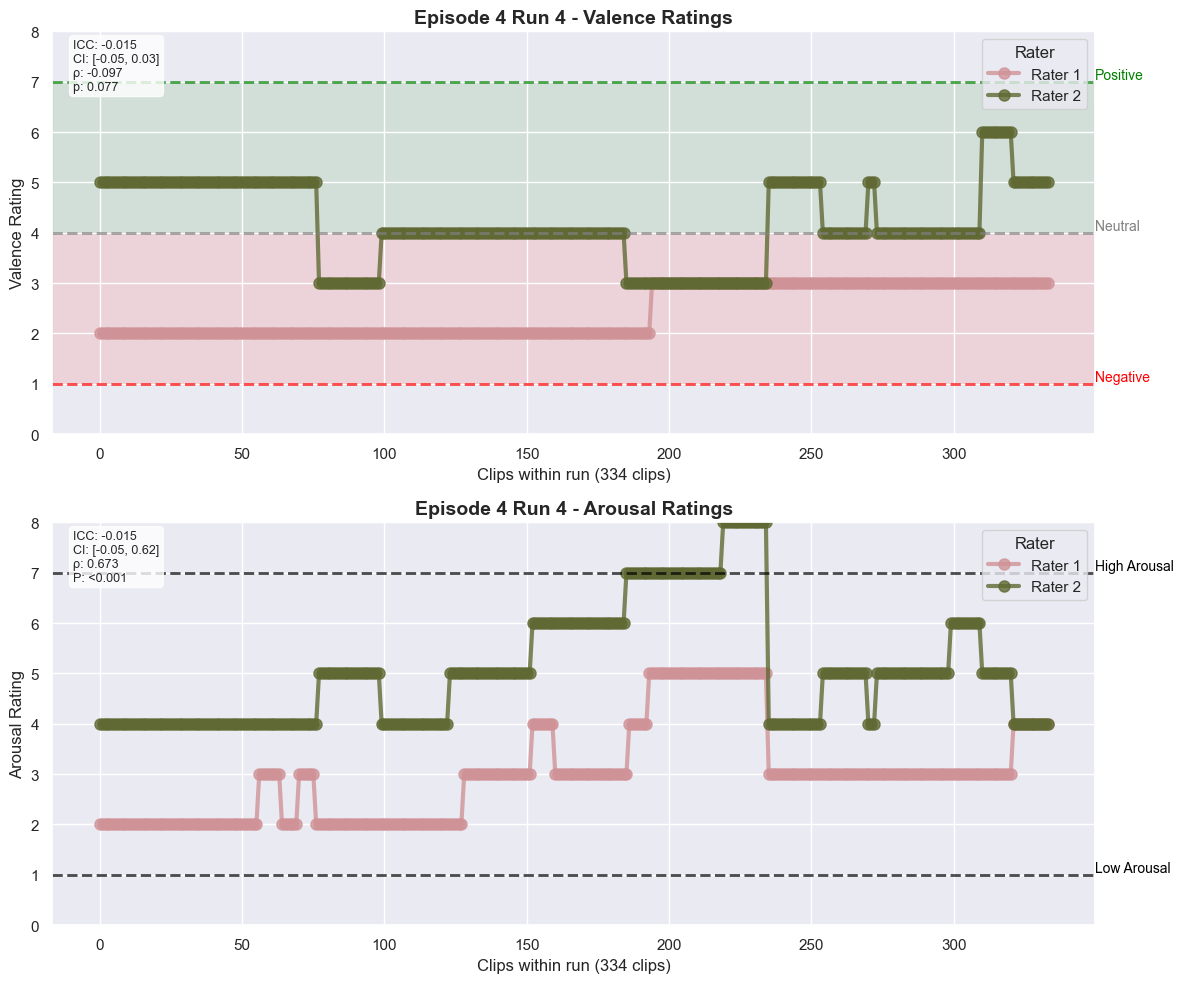

  Creating plot for Run 5 (230 clips)
    📁 Figure saved: derivatives/figures/episode_04_run_05_emotion_ratings.png
    📁 Figure saved: derivatives/figures/episode_04_run_05_emotion_ratings.png


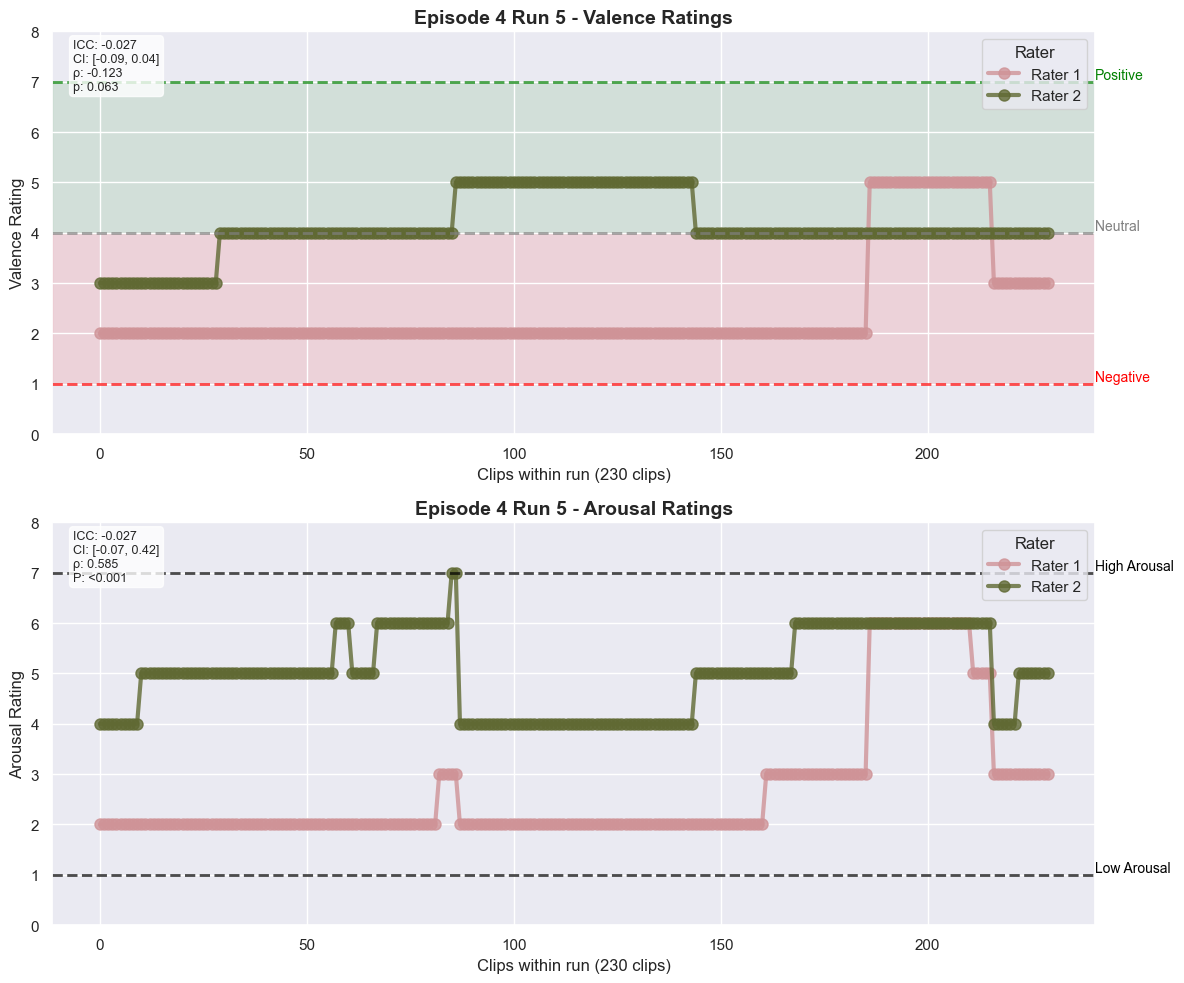


All individual run plots completed!


In [5]:
# Individual Run Plotting - Save each run as separate figure with statistical results
# Load the run-level reliability results
run_reliability_results = pd.read_csv(OUT_DIR / "interrater_reliability_by_run.csv")

episode_numbers = [1,2,3,4]

for ep_num in episode_numbers:
    episode_file = ANNOT_DIR / f"S01E{ep_num:02d}.csv"
    episode_name = Path(episode_file).stem  # e.g., "S01E01"
    print(f"\n{'='*60}")
    print(f"Creating individual run plots for {episode_name}")
    print(f"{'='*60}")
    
    # Load episode data
    episode_df = pd.read_csv(episode_file)
    
    # Find rating columns
    val_cols = [c for c in episode_df.columns if 'valence' in c.lower()]
    aro_cols = [c for c in episode_df.columns if 'arousal' in c.lower()]

    # Extract clip number from 'index' like S01E01R01_clip0007 -> 7
    pattern = rf"{re.escape(episode_name)}R\d{{2}}_clip(\d+)"
    extracted = episode_df['index'].astype(str).str.extract(pattern, expand=False)

    episode_df = episode_df[extracted.notna()].copy()
    episode_df['clip_number'] = extracted[extracted.notna()].astype(int)
    
    # Extract run number (e.g., "S01E01R01" -> 1)
    episode_df['run_number'] = episode_df['run'].str.extract(r'R(\d+)').astype(int)
    
    # Create sequential position: run order first, then clip order within run
    episode_df = episode_df.sort_values(['run_number', 'clip_number'])
    episode_df['sequential_position'] = range(len(episode_df))

    # Process each run separately
    unique_runs = sorted(episode_df['run_number'].unique())
    
    for run_num in unique_runs:
        run_data = episode_df[episode_df['run_number'] == run_num].copy()
        run_data = run_data.sort_values('clip_number')
        run_data['run_position'] = range(len(run_data))
        
        print(f"  Creating plot for Run {run_num} ({len(run_data)} clips)")
        
        # ---- Make LONG data with rater column for this run ----
        # Valence: columns valence_1, valence_2 -> rows with rater=1/2
        valence_long = run_data.melt(
            id_vars=['run_position', 'clip_number'],
            value_vars=val_cols,
            var_name='rater',
            value_name='valence'
        )
        valence_long['rater'] = valence_long['rater'].str.extract(r'(\d+)', expand=False).astype(int)

        # Arousal: columns arousal_1, arousal_2 -> rows with rater=1/2
        arousal_long = run_data.melt(
            id_vars=['run_position', 'clip_number'],
            value_vars=aro_cols,
            var_name='rater',
            value_name='arousal'
        )
        arousal_long['rater'] = arousal_long['rater'].str.extract(r'(\d+)', expand=False).astype(int)

        # ---- Plot ----
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

        # Valence plot
        if not valence_long.empty:
            ax1.axhspan(1, 4, alpha=0.1, color='red', zorder=0)
            ax1.axhspan(4, 7, alpha=0.1, color='green', zorder=0)

            # Plot each rater separately with explicit colors
            for i, rater in enumerate(sorted(valence_long['rater'].unique())):
                rater_data = valence_long[valence_long['rater'] == rater].sort_values('run_position')
                ax1.plot(rater_data['run_position'], rater_data['valence'], 
                        color=colors[i % len(colors)], marker='o', markersize=8, linewidth=3, 
                        alpha=0.8, label=f'Rater {rater}')
            
            ax1.set_title(f'Episode {ep_num} Run {run_num} - Valence Ratings', fontsize=14, fontweight='bold')
            ax1.set_xlabel(f'Clips within run ({len(run_data)} clips)', fontsize=12)
            ax1.set_ylabel('Valence Rating', fontsize=12)
            ax1.set_ylim(0, 8)
            ax1.legend(title='Rater', loc='upper right')

            # Add reference lines
            ax1.axhline(y=1, color='red', linestyle='--', alpha=0.7, linewidth=2)
            ax1.axhline(y=4, color='gray', linestyle='--', alpha=0.7, linewidth=2)
            ax1.axhline(y=7, color='green', linestyle='--', alpha=0.7, linewidth=2)
            
            # Add text labels
            x_right = ax1.get_xlim()[1]
            ax1.text(x_right, 1, 'Negative', ha='left', va='bottom', fontsize=10, color='red')
            ax1.text(x_right, 4, 'Neutral', ha='left', va='bottom', fontsize=10, color='gray')
            ax1.text(x_right, 7, 'Positive', ha='left', va='bottom', fontsize=10, color='green')
            
            # Add run-specific statistical results in top left
            run_stats = run_reliability_results[
                (run_reliability_results['Episode'] == ep_num) & 
                (run_reliability_results['Run'] == run_num)
            ]
            if not run_stats.empty:
                run_stat = run_stats.iloc[0]
                val_icc = run_stat['Valence_ICC']
                val_ci_lower = run_stat['Valence_ICC_CI_Lower']
                val_ci_upper = run_stat['Valence_ICC_CI_Upper']
                val_spearman = run_stat['Valence_Spearman_r']
                val_spearman_p = run_stat['Valence_Spearman_pval']
                
                stats_text = []
                if pd.notna(val_icc):
                    # Format ICC with scientific notation if very small
                    if abs(val_icc) < 0.001 and val_icc != 0:
                        # Convert to scientific notation with proper superscript formatting
                        mantissa = val_icc / (10 ** int(np.floor(np.log10(abs(val_icc)))))
                        exponent = int(np.floor(np.log10(abs(val_icc))))
                        icc_str = f"{mantissa:.2f}×10$^{{{exponent}}}$"
                    else:
                        icc_str = f"{val_icc:.3f}"
                    stats_text.append(f"ICC: {icc_str}")
                    if pd.notna(val_ci_lower) and pd.notna(val_ci_upper):
                        stats_text.append(f"CI: [{val_ci_lower:.2f}, {val_ci_upper:.2f}]")
                if pd.notna(val_spearman):
                    # Format Spearman r with scientific notation if very small
                    if abs(val_spearman) < 0.001 and val_spearman != 0:
                        # Convert to scientific notation with proper superscript formatting
                        mantissa = val_spearman / (10 ** int(np.floor(np.log10(abs(val_spearman)))))
                        exponent = int(np.floor(np.log10(abs(val_spearman))))
                        spearman_str = f"{mantissa:.2f}×10$^{{{exponent}}}$"
                    else:
                        spearman_str = f"{val_spearman:.3f}"
                    stats_text.append(f"ρ: {spearman_str}")
                    if pd.notna(val_spearman_p):
                        p_str = f"{val_spearman_p:.3f}" if val_spearman_p >= 0.001 else "<0.001"
                        stats_text.append(f"p: {p_str}")
                
                if stats_text:
                    ax1.text(0.02, 0.98, '\n'.join(stats_text), transform=ax1.transAxes,
                            fontsize=9, verticalalignment='top', horizontalalignment='left',
                            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        else:
            ax1.set_title('No valence columns found')

        # Arousal plot
        if not arousal_long.empty:
            # Plot each rater separately with explicit colors
            for i, rater in enumerate(sorted(arousal_long['rater'].unique())):
                rater_data = arousal_long[arousal_long['rater'] == rater].sort_values('run_position')
                ax2.plot(rater_data['run_position'], rater_data['arousal'], 
                        color=colors[i % len(colors)], marker='o', markersize=8, linewidth=3, 
                        alpha=0.8, label=f'Rater {rater}')
            
            ax2.set_title(f'Episode {ep_num} Run {run_num} - Arousal Ratings', fontsize=14, fontweight='bold')
            ax2.set_xlabel(f'Clips within run ({len(run_data)} clips)', fontsize=12)
            ax2.set_ylabel('Arousal Rating', fontsize=12)
            ax2.set_ylim(0, 8)
            ax2.legend(title='Rater', loc='upper right')

            # Add reference lines
            ax2.axhline(y=1, color='black', linestyle='--', alpha=0.7, linewidth=2)
            ax2.axhline(y=7, color='black', linestyle='--', alpha=0.7, linewidth=2)
            
            # Add text labels
            x_right = ax2.get_xlim()[1]
            ax2.text(x_right, 1, 'Low Arousal', ha='left', va='bottom', fontsize=10, color='black')
            ax2.text(x_right, 7, 'High Arousal', ha='left', va='bottom', fontsize=10, color='black')
            
            # Add run-specific arousal statistical results in top left
            if not run_stats.empty:
                aro_icc = run_stat['Arousal_ICC']
                aro_ci_lower = run_stat['Arousal_ICC_CI_Lower']
                aro_ci_upper = run_stat['Arousal_ICC_CI_Upper']
                aro_spearman = run_stat['Arousal_Spearman_r']
                aro_spearman_p = run_stat['Arousal_Spearman_pval']
                
                stats_text = []
                if pd.notna(aro_icc):
                    # Format ICC with scientific notation if very small
                    if abs(val_icc) < 0.001 and val_icc != 0:
                        # Convert to scientific notation with proper superscript formatting
                        mantissa = val_icc / (10 ** int(np.floor(np.log10(abs(val_icc)))))
                        exponent = int(np.floor(np.log10(abs(val_icc))))
                        icc_str = f"{mantissa:.2f}×10$^{{{exponent}}}$"
                    else:
                        icc_str = f"{val_icc:.3f}"
                    stats_text.append(f"ICC: {icc_str}")
                    if pd.notna(aro_ci_lower) and pd.notna(aro_ci_upper):
                        stats_text.append(f"CI: [{aro_ci_lower:.2f}, {aro_ci_upper:.2f}]")
                if pd.notna(aro_spearman):
                    # Format Spearman r with scientific notation if very small
                    if abs(aro_spearman) < 0.001 and aro_spearman != 0:
                        # Convert to scientific notation with proper superscript formatting
                        mantissa = aro_spearman / (10 ** int(np.floor(np.log10(abs(aro_spearman)))))
                        exponent = int(np.floor(np.log10(abs(aro_spearman))))
                        spearman_str = f"{mantissa:.2f}×10$^{{{exponent}}}$"
                    else:
                        spearman_str = f"{aro_spearman:.3f}"
                    stats_text.append(f"ρ: {spearman_str}")
                    if pd.notna(aro_spearman_p):
                        p_str = f"{aro_spearman_p:.3f}" if aro_spearman_p >= 0.001 else "<0.001"
                        stats_text.append(f"P: {p_str}")
                
                if stats_text:
                    ax2.text(0.02, 0.98, '\n'.join(stats_text), transform=ax2.transAxes,
                            fontsize=9, verticalalignment='top', horizontalalignment='left',
                            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        else:
            ax2.set_title('No arousal columns found')

        plt.tight_layout()
        
        # Save figure with 300 DPI - individual run
        figure_filename = f"episode_{ep_num:02d}_run_{run_num:02d}_emotion_ratings.png"
        figure_path = FIGURES_DIR / figure_filename
        fig.savefig(figure_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"    📁 Figure saved: {figure_path}")
        
        plt.show()

print(f"\n{'='*60}")
print("All individual run plots completed!")
print(f"{'='*60}")

In [6]:
# Save all figures in one PDF
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

# Create PDF file
pdf_filename = FIGURES_DIR / "all_emotion_ratings.pdf"

with PdfPages(pdf_filename) as pdf:
    print(f"Creating comprehensive PDF: {pdf_filename}")
    print(f"{'='*60}")
    
    # Load the overall and run-level reliability results
    reliability_results = pd.read_csv(OUT_DIR / "interrater_reliability_overall.csv")
    run_reliability_results = pd.read_csv(OUT_DIR / "interrater_reliability_by_run.csv")
    
    episode_numbers = [1,2,3,4]
    
    for ep_num in episode_numbers:
        episode_file = ANNOT_DIR / f"S01E{ep_num:02d}.csv"
        episode_name = Path(episode_file).stem
        print(f"Adding Episode {ep_num} plots to PDF...")
        
        # Load episode data
        episode_df = pd.read_csv(episode_file)
        
        # Find rating columns
        val_cols = [c for c in episode_df.columns if 'valence' in c.lower()]
        aro_cols = [c for c in episode_df.columns if 'arousal' in c.lower()]

        # Extract clip and run info
        pattern = rf"{re.escape(episode_name)}R\d{{2}}_clip(\d+)"
        extracted = episode_df['index'].astype(str).str.extract(pattern, expand=False)

        episode_df = episode_df[extracted.notna()].copy()
        episode_df['clip_number'] = extracted[extracted.notna()].astype(int)
        episode_df['run_number'] = episode_df['run'].str.extract(r'R(\d+)').astype(int)
        episode_df = episode_df.sort_values(['run_number', 'clip_number'])
        episode_df['sequential_position'] = range(len(episode_df))

        # === EPISODE OVERVIEW PLOT ===
        valence_long = episode_df.melt(
            id_vars=['sequential_position', 'run', 'clip_number'],
            value_vars=val_cols, var_name='rater', value_name='valence'
        )
        valence_long['rater'] = valence_long['rater'].str.extract(r'(\d+)', expand=False).astype(int)

        arousal_long = episode_df.melt(
            id_vars=['sequential_position', 'run', 'clip_number'],
            value_vars=aro_cols, var_name='rater', value_name='arousal'
        )
        arousal_long['rater'] = arousal_long['rater'].str.extract(r'(\d+)', expand=False).astype(int)

        # Create episode overview plot
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
        total_trs = len(episode_df)

        # Valence plot
        if not valence_long.empty:
            ax1.axhspan(1, 4, alpha=0.1, color='red', zorder=0)
            ax1.axhspan(4, 7, alpha=0.1, color='green', zorder=0)

            for i, rater in enumerate(sorted(valence_long['rater'].unique())):
                rater_data = valence_long[valence_long['rater'] == rater].sort_values('sequential_position')
                ax1.plot(rater_data['sequential_position'], rater_data['valence'], 
                        color=colors[i % len(colors)], marker='o', markersize=6, linewidth=2.5, 
                        alpha=0.8, label=f'Rater {rater}')
            
            ax1.set_title(f'Episode {ep_num} Valence Ratings - Overview', fontsize=16, fontweight='bold')
            ax1.set_xlabel(f'Clips ({total_trs} total volumes across all runs)', fontsize=12)
            ax1.set_ylabel('Valence Rating', fontsize=12)
            ax1.set_ylim(0, 8)
            ax1.legend(title='Rater', loc='upper right')

            # Add reference lines and labels
            ax1.axhline(y=1, color='red', linestyle='--', alpha=0.7, linewidth=2)
            ax1.axhline(y=4, color='gray', linestyle='--', alpha=0.7, linewidth=2)
            ax1.axhline(y=7, color='green', linestyle='--', alpha=0.7, linewidth=2)
            
            x_right = ax1.get_xlim()[1]
            ax1.text(x_right, 1, 'Negative Valence', ha='left', va='bottom', fontsize=12, color='red')
            ax1.text(x_right, 4, 'Neutral', ha='left', va='bottom', fontsize=12, color='gray')
            ax1.text(x_right, 7, 'Positive Valence', ha='left', va='bottom', fontsize=12, color='green')
            
            # Add statistical results
            ep_stats = reliability_results[reliability_results['Episode'] == ep_num].iloc[0]
            val_icc = ep_stats['Valence_ICC']
            val_ci_lower = ep_stats['Valence_ICC_CI_Lower']
            val_ci_upper = ep_stats['Valence_ICC_CI_Upper']
            val_spearman = ep_stats['Valence_Spearman_r']
            val_spearman_p = ep_stats['Valence_Spearman_pval']
            
            stats_text = []
            if pd.notna(val_icc):
                # Format ICC with scientific notation if very small
                if abs(val_icc) < 0.001 and val_icc != 0:
                    # Convert to scientific notation with proper superscript formatting
                    mantissa = val_icc / (10 ** int(np.floor(np.log10(abs(val_icc)))))
                    exponent = int(np.floor(np.log10(abs(val_icc))))
                    icc_str = f"{mantissa:.2f}×10$^{{{exponent}}}$"
                else:
                    icc_str = f"{val_icc:.3f}"
                stats_text.append(f"ICC: {icc_str}")
                if pd.notna(val_ci_lower) and pd.notna(val_ci_upper):
                    stats_text.append(f"CI: [{val_ci_lower:.2f}, {val_ci_upper:.2f}]")
            if pd.notna(val_spearman):
                # Format Spearman r with scientific notation if very small
                if abs(val_spearman) < 0.001 and val_spearman != 0:
                    # Convert to scientific notation with proper superscript formatting
                    mantissa = val_spearman / (10 ** int(np.floor(np.log10(abs(val_spearman)))))
                    exponent = int(np.floor(np.log10(abs(val_spearman))))
                    spearman_str = f"{mantissa:.2f}×10$^{{{exponent}}}$"
                else:
                    spearman_str = f"{val_spearman:.3f}"
                stats_text.append(f"ρ: {spearman_str}")
                if pd.notna(val_spearman_p):
                    p_str = f"{val_spearman_p:.3f}" if val_spearman_p >= 0.001 else "<0.001"
                    stats_text.append(f"p: {p_str}")
            
            if stats_text:
                ax1.text(0.02, 0.98, '\n'.join(stats_text), transform=ax1.transAxes,
                        fontsize=10, verticalalignment='top', horizontalalignment='left',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

        # Arousal plot
        if not arousal_long.empty:
            for i, rater in enumerate(sorted(arousal_long['rater'].unique())):
                rater_data = arousal_long[arousal_long['rater'] == rater].sort_values('sequential_position')
                ax2.plot(rater_data['sequential_position'], rater_data['arousal'], 
                        color=colors[i % len(colors)], marker='o', markersize=6, linewidth=2.5, 
                        alpha=0.8, label=f'Rater {rater}')
            
            ax2.set_title(f'Episode {ep_num} Arousal Ratings - Overview', fontsize=16, fontweight='bold')
            ax2.set_xlabel(f'Clips ({total_trs} total volumes across all runs)', fontsize=12)
            ax2.set_ylabel('Arousal Rating', fontsize=12)
            ax2.set_ylim(0, 8)
            ax2.legend(title='Rater', loc='upper right')

            # Add reference lines and labels
            ax2.axhline(y=1, color='black', linestyle='--', alpha=0.7, linewidth=2)
            ax2.axhline(y=7, color='black', linestyle='--', alpha=0.7, linewidth=2)
            
            x_right = ax2.get_xlim()[1]
            ax2.text(x_right, 1, 'Low Arousal', ha='left', va='bottom', fontsize=12, color='black')
            ax2.text(x_right, 7, 'High Arousal', ha='left', va='bottom', fontsize=12, color='black')
            
            # Add statistical results
            aro_icc = ep_stats['Arousal_ICC']
            aro_ci_lower = ep_stats['Arousal_ICC_CI_Lower']
            aro_ci_upper = ep_stats['Arousal_ICC_CI_Upper']
            aro_spearman = ep_stats['Arousal_Spearman_r']
            aro_spearman_p = ep_stats['Arousal_Spearman_pval']
            
            stats_text = []
            if pd.notna(aro_icc):
                # Format ICC with scientific notation if very small
                if abs(aro_icc) < 0.001 and aro_icc != 0:
                    icc_str = f"{aro_icc:.2e}".replace("e", "×10^")
                else:
                    icc_str = f"{aro_icc:.3f}"
                stats_text.append(f"ICC: {icc_str}")
                if pd.notna(aro_ci_lower) and pd.notna(aro_ci_upper):
                    stats_text.append(f"CI: [{aro_ci_lower:.2f}, {aro_ci_upper:.2f}]")
            if pd.notna(aro_spearman):
                # Format Spearman r with scientific notation if very small
                if abs(aro_spearman) < 0.001 and aro_spearman != 0:
                    spearman_str = f"{aro_spearman:.2e}".replace("e", "×10^")
                else:
                    spearman_str = f"{aro_spearman:.3f}"
                stats_text.append(f"ρ: {spearman_str}")
                if pd.notna(aro_spearman_p):
                    p_str = f"{aro_spearman_p:.3f}" if aro_spearman_p >= 0.001 else "<0.001"
                    stats_text.append(f"P: {p_str}")
            
            if stats_text:
                ax2.text(0.02, 0.98, '\n'.join(stats_text), transform=ax2.transAxes,
                        fontsize=10, verticalalignment='top', horizontalalignment='left',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

        plt.tight_layout()
        pdf.savefig(fig, dpi=300, bbox_inches='tight')
        plt.close(fig)

        # === INDIVIDUAL RUN PLOTS ===
        unique_runs = sorted(episode_df['run_number'].unique())
        
        for run_num in unique_runs:
            run_data = episode_df[episode_df['run_number'] == run_num].copy()
            run_data = run_data.sort_values('clip_number')
            run_data['run_position'] = range(len(run_data))
            
            # Create run-specific data
            valence_long_run = run_data.melt(
                id_vars=['run_position', 'clip_number'], value_vars=val_cols,
                var_name='rater', value_name='valence'
            )
            valence_long_run['rater'] = valence_long_run['rater'].str.extract(r'(\d+)', expand=False).astype(int)

            arousal_long_run = run_data.melt(
                id_vars=['run_position', 'clip_number'], value_vars=aro_cols,
                var_name='rater', value_name='arousal'
            )
            arousal_long_run['rater'] = arousal_long_run['rater'].str.extract(r'(\d+)', expand=False).astype(int)

            # Create run plot
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

            # Valence plot
            if not valence_long_run.empty:
                ax1.axhspan(1, 4, alpha=0.1, color='red', zorder=0)
                ax1.axhspan(4, 7, alpha=0.1, color='green', zorder=0)

                for i, rater in enumerate(sorted(valence_long_run['rater'].unique())):
                    rater_data = valence_long_run[valence_long_run['rater'] == rater].sort_values('run_position')
                    ax1.plot(rater_data['run_position'], rater_data['valence'], 
                            color=colors[i % len(colors)], marker='o', markersize=8, linewidth=3, 
                            alpha=0.8, label=f'Rater {rater}')
                
                ax1.set_title(f'Episode {ep_num} Run {run_num} - Valence Ratings', fontsize=14, fontweight='bold')
                ax1.set_xlabel(f'Clips within run ({len(run_data)} clips)', fontsize=12)
                ax1.set_ylabel('Valence Rating', fontsize=12)
                ax1.set_ylim(0, 8)
                ax1.legend(title='Rater', loc='upper right')

                # Add reference lines and labels
                ax1.axhline(y=1, color='red', linestyle='--', alpha=0.7, linewidth=2)
                ax1.axhline(y=4, color='gray', linestyle='--', alpha=0.7, linewidth=2)
                ax1.axhline(y=7, color='green', linestyle='--', alpha=0.7, linewidth=2)
                
                x_right = ax1.get_xlim()[1]
                ax1.text(x_right, 1, 'Negative', ha='left', va='bottom', fontsize=10, color='red')
                ax1.text(x_right, 4, 'Neutral', ha='left', va='bottom', fontsize=10, color='gray')
                ax1.text(x_right, 7, 'Positive', ha='left', va='bottom', fontsize=10, color='green')
                
                # Add run-specific statistical results
                run_stats = run_reliability_results[
                    (run_reliability_results['Episode'] == ep_num) & 
                    (run_reliability_results['Run'] == run_num)
                ]
                if not run_stats.empty:
                    run_stat = run_stats.iloc[0]
                    val_icc = run_stat['Valence_ICC']
                    val_ci_lower = run_stat['Valence_ICC_CI_Lower']
                    val_ci_upper = run_stat['Valence_ICC_CI_Upper']
                    val_spearman = run_stat['Valence_Spearman_r']
                    val_spearman_p = run_stat['Valence_Spearman_pval']
                    
                    stats_text = []
                    if pd.notna(val_icc):
                        # Format ICC with scientific notation if very small
                        if abs(val_icc) < 0.001 and val_icc != 0:
                            icc_str = f"{val_icc:.2e}".replace("e", "×10^")
                        else:
                            icc_str = f"{val_icc:.3f}"
                        stats_text.append(f"ICC: {icc_str}")
                        if pd.notna(val_ci_lower) and pd.notna(val_ci_upper):
                            stats_text.append(f"CI: [{val_ci_lower:.2f}, {val_ci_upper:.2f}]")
                    if pd.notna(val_spearman):
                        # Format Spearman r with scientific notation if very small
                        if abs(val_spearman) < 0.001 and val_spearman != 0:
                            spearman_str = f"{val_spearman:.2e}".replace("e", "×10^")
                        else:
                            spearman_str = f"{val_spearman:.3f}"
                        stats_text.append(f"ρ: {spearman_str}")
                        if pd.notna(val_spearman_p):
                            p_str = f"{val_spearman_p:.3f}" if val_spearman_p >= 0.001 else "<0.001"
                            stats_text.append(f"p: {p_str}")
                    
                    if stats_text:
                        ax1.text(0.02, 0.98, '\n'.join(stats_text), transform=ax1.transAxes,
                                fontsize=9, verticalalignment='top', horizontalalignment='left',
                                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

            # Arousal plot
            if not arousal_long_run.empty:
                for i, rater in enumerate(sorted(arousal_long_run['rater'].unique())):
                    rater_data = arousal_long_run[arousal_long_run['rater'] == rater].sort_values('run_position')
                    ax2.plot(rater_data['run_position'], rater_data['arousal'], 
                            color=colors[i % len(colors)], marker='o', markersize=8, linewidth=3, 
                            alpha=0.8, label=f'Rater {rater}')
                
                ax2.set_title(f'Episode {ep_num} Run {run_num} - Arousal Ratings', fontsize=14, fontweight='bold')
                ax2.set_xlabel(f'Clips within run ({len(run_data)} clips)', fontsize=12)
                ax2.set_ylabel('Arousal Rating', fontsize=12)
                ax2.set_ylim(0, 8)
                ax2.legend(title='Rater', loc='upper right')

                # Add reference lines and labels
                ax2.axhline(y=1, color='black', linestyle='--', alpha=0.7, linewidth=2)
                ax2.axhline(y=7, color='black', linestyle='--', alpha=0.7, linewidth=2)
                
                x_right = ax2.get_xlim()[1]
                ax2.text(x_right, 1, 'Low Arousal', ha='left', va='bottom', fontsize=10, color='black')
                ax2.text(x_right, 7, 'High Arousal', ha='left', va='bottom', fontsize=10, color='black')
                
                # Add run-specific arousal statistical results
                if not run_stats.empty:
                    aro_icc = run_stat['Arousal_ICC']
                    aro_ci_lower = run_stat['Arousal_ICC_CI_Lower']
                    aro_ci_upper = run_stat['Arousal_ICC_CI_Upper']
                    aro_spearman = run_stat['Arousal_Spearman_r']
                    aro_spearman_p = run_stat['Arousal_Spearman_pval']
                    
                    stats_text = []
                    if pd.notna(aro_icc):
                        # Format ICC with scientific notation if very small
                        if abs(aro_icc) < 0.001 and aro_icc != 0:
                            icc_str = f"{aro_icc:.2e}".replace("e", "×10^")
                        else:
                            icc_str = f"{aro_icc:.3f}"
                        stats_text.append(f"ICC: {icc_str}")
                        if pd.notna(aro_ci_lower) and pd.notna(aro_ci_upper):
                            stats_text.append(f"CI: [{aro_ci_lower:.2f}, {aro_ci_upper:.2f}]")
                    if pd.notna(aro_spearman):
                        # Format Spearman r with scientific notation if very small
                        if abs(aro_spearman) < 0.001 and aro_spearman != 0:
                            spearman_str = f"{aro_spearman:.2e}".replace("e", "×10^")
                        else:
                            spearman_str = f"{aro_spearman:.3f}"
                        stats_text.append(f"ρ: {spearman_str}")
                        if pd.notna(aro_spearman_p):
                            p_str = f"{aro_spearman_p:.3f}" if aro_spearman_p >= 0.001 else "<0.001"
                            stats_text.append(f"P: {p_str}")
                    
                    if stats_text:
                        ax2.text(0.02, 0.98, '\n'.join(stats_text), transform=ax2.transAxes,
                                fontsize=9, verticalalignment='top', horizontalalignment='left',
                                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

            plt.tight_layout()
            pdf.savefig(fig, dpi=300, bbox_inches='tight')
            plt.close(fig)

print(f"\n{'='*60}")
print(f"📄 PDF saved: {pdf_filename}")
print(f"Contains: {len(episode_numbers)} episode overviews + individual run plots")
print(f"{'='*60}")

Creating comprehensive PDF: derivatives/figures/all_emotion_ratings.pdf
Adding Episode 1 plots to PDF...
Adding Episode 2 plots to PDF...
Adding Episode 2 plots to PDF...
Adding Episode 3 plots to PDF...
Adding Episode 3 plots to PDF...
Adding Episode 4 plots to PDF...
Adding Episode 4 plots to PDF...

📄 PDF saved: derivatives/figures/all_emotion_ratings.pdf
Contains: 4 episode overviews + individual run plots

📄 PDF saved: derivatives/figures/all_emotion_ratings.pdf
Contains: 4 episode overviews + individual run plots
